## **数据挖掘项目 - 电信用户行为预测**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, f1_score, roc_auc_score, mean_squared_error, mean_absolute_error, classification_report)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = pd.read_csv(r"D:\Desktop\数据挖掘_个人大作业2\TeleComm_User_Info.txt", encoding="gbk")

### **数据预处理、探索性数据分析与特征工程**

In [2]:
# 统一数据加载与基础清洗
def load_and_clean_telecom(df):
    """
    加载 TeleComm_User_Info.txt，并做统一的基础清洗：
    1. 读取 txt（逗号分隔）
    2. 规范列名，去掉首尾空格
    3. 显式转换关键数值列为 numeric
    4. 去重（按用户ID）
    
    注意：这里不做“按任务”的删行/删列，只保证数据类型正确、结构干净。
         与具体任务强相关的过滤（如只保留公众客户、只保留某些取值）放在各任务内部做。
    """
    print("\n" + "=" * 60)
    print("【步骤1】加载原始数据")
    print("=" * 60)
    print(f"原始数据：{df.shape[0]} 行，{df.shape[1]} 列")

    # 规范列名：去掉首尾空格
    df.columns = [c.strip() for c in df.columns]

    # 将明显的数值列转为 numeric（错误转为 NaN）
    numeric_cols = [
        "年龄", "在网时长",
        "上网流量使用", "漫游流量使用",
        "总收入", "增值收入", "流量收入",
        "短信收入", "彩信收入", "语音收入"
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # 按用户ID 去重（如果有）
    if "用户ID" in df.columns:
        before = df.shape[0]
        df = df.drop_duplicates(subset=["用户ID"])
        after = df.shape[0]
        if after < before:
            print(f"去重：按 用户ID 删除重复记录 {before - after} 条")

    print("基础清洗完成。")
    print("=" * 60)
    return df

# 数据探索与描述性统计
def explore_telecom_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    对电信数据做全局探索，并聚焦客户类型='公众客户'的描述性统计。
    返回：仅含公众客户的子集 df_public，用于后续任务分析。

    思路：
    1. 全局概览：规模、字段、缺失情况
    2. 关键变量（目标相关）的分布：客户类型、是否欠费、终端类型、渠道、操作系统
    3. 对 [客户类型='公众客户'] 做一轮针对性的描述统计
    """

    print("\n" + "=" * 60)
    print("【步骤2】全局数据探索")
    print("=" * 60)

    # 1. 基本结构
    print("\n[1] 数据基本信息")
    print(f"记录数：{df.shape[0]}，字段数：{df.shape[1]}")
    print("列名：", list(df.columns))

    # 2. 缺失值概览
    print("\n[2] 缺失值概览")
    missing = df.isnull().sum()
    missing_table = pd.DataFrame({
        "缺失数量": missing,
        "缺失比例(%)": (missing / len(df) * 100).round(2)
    })
    print(missing_table[missing_table["缺失数量"] > 0].sort_values("缺失数量", ascending=False))

    # 3. 只保留“公众客户” —— 这是后续所有任务的分析对象
    print("\n" + "=" * 60)
    print("【步骤3】聚焦公众客户（后续任务统一使用这个子集）")
    print("=" * 60)
    df_public = df[df["客户类型"] == "公众客户"].copy()
    print(f"公众客户样本数：{df_public.shape[0]} "
          f"(占全部用户 {df_public.shape[0] / len(df) * 100:.2f}%)")

    generate_descriptive_analysis(df_public)

    # 5. 公众客户中的目标变量分布（和后续五个任务直接相关）
    print("\n[5] 公众客户中，目标相关变量的分布")

    # 任务2: 是否欠费
    if "是否欠费" in df_public.columns:
        vc = df_public["是否欠费"].value_counts()
        print("\n(1) 是否欠费 分布（公众客户）")
        print(vc)
        print("占比(%)：")
        print((vc / len(df_public) * 100).round(2))

    # 任务3: 终端类型
    if "终端类型" in df_public.columns:
        vc = df_public["终端类型"].value_counts()
        print("\n(2) 终端类型 分布（公众客户）")
        print(vc)
        print("占比(%)：")
        print((vc / len(df_public) * 100).round(2))

    # 任务4: 渠道类型描述
    if "渠道类型描述" in df_public.columns:
        vc = df_public["渠道类型描述"].value_counts()
        print("\n(3) 渠道类型描述 分布（公众客户）")
        print(vc)
        print("占比(%)：")
        print((vc / len(df_public) * 100).round(2))

    # 任务5: 最近使用操作系统偏好（只看 ANDROID / IOS 的占比）
    if "最近使用操作系统偏好" in df_public.columns:
        print("\n(4) 操作系统偏好（公众客户，原始取值 Top10）")
        vc_os = df_public["最近使用操作系统偏好"].value_counts().head(10)
        print(vc_os)
        print("占比(%)：")
        print((vc_os / len(df_public) * 100).round(2))
        # 发现有诸如"ANDROID 5.1"这样具体版本的数据，后面任务5将它们聚合到 ANDROID / IOS 两大类

    # 6. 公众客户的收入结构 & 使用行为，大致看看水平（为任务1埋个伏笔）
    focus_cols = ["总收入", "增值收入", "流量收入", "短信收入", "彩信收入", "语音收入", "在网时长", "上网流量使用",
                  "漫游流量使用"]

    print("\n[6] 公众客户的收入与使用行为数据概览：")
    print(df_public[focus_cols].describe().T)

    print("\n[7] 收入/使用行为之间的相关系数矩阵（部分）：")
    corr_matrix = df_public[focus_cols].corr().round(2)
    print(corr_matrix)

    # --- 新增代码：绘制相关系数热力图（修复字体问题） ---
    print("\n[8] 相关系数热力图：")
    if not corr_matrix.empty:
        plt.figure(figsize=(14, 12))

        # --- 关键修复：为热力图指定字体 ---
        # 从之前的 generate_descriptive_analysis 函数中借鉴字体加载逻辑
        from matplotlib.font_manager import FontProperties
        font = None
        try:
            font = FontProperties(family='SimHei', size=10)
            font.get_name()
        except Exception:
            fallback_fonts = ['Microsoft YaHei', 'DengXian', 'WenQuanYi Micro Hei']
            for font_name in fallback_fonts:
                try:
                    font = FontProperties(family=font_name, size=10)
                    font.get_name()
                    break
                except Exception:
                    continue
        
        if font:
            # 使用 seaborn 绘制热力图，并通过 annot_kws 参数传递字体
            sns.heatmap(
                corr_matrix,
                cmap='coolwarm',
                annot=True,
                fmt='.2f',
                linewidths=.5,
                cbar_kws={"shrink": .8},
                annot_kws={'fontproperties': font}  # 为热力图内的数字指定字体
            )

            # 为坐标轴标签和标题指定字体
            plt.title('公众客户关键指标相关性热力图', fontproperties=font, fontsize=18, pad=20)
            plt.xticks(rotation=45, ha='right', fontproperties=font)
            plt.yticks(rotation=0, fontproperties=font)
        else:
            # 如果没有找到字体，绘制但不保证中文显示
            sns.heatmap(
                corr_matrix,
                cmap='coolwarm',
                annot=True,
                fmt='.2f',
                linewidths=.5,
                cbar_kws={"shrink": .8}
            )
            plt.title('公众客户关键指标相关性热力图', fontsize=18, pad=20)
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)

        # 调整布局，防止标签被截断
        plt.tight_layout()
        plt.show()
    else:
        print("警告：无法生成热力图，因为相关系数矩阵为空。")

    print("\n数据探索完成。后续所有建模任务统一使用 df_public。")
    return df_public

def generate_descriptive_analysis(df_public):
    """
    为公众客户数据生成描述性统计图表。
    参数:
    df_public (pd.DataFrame): 仅包含"公众客户"的数据框。
    """
    print("\n" + "="*60)
    print("【步骤4】公众客户数据描述性统计与可视化")
    print("="*60)
    
    # 检查系统中是否存在 SimHei，如果没有则尝试其他常见中文字体
    from matplotlib.font_manager import FontProperties
    font = None  # 初始化字体对象
    try:
        # 尝试创建 SimHei 字体对象
        font = FontProperties(family='SimHei', size=12)
        font.get_name()  # 测试字体是否有效
        print(f"成功加载中文字体：{font.get_name()}")
    except Exception:
        # 如果 SimHei 找不到，尝试其他字体
        fallback_fonts = ['Microsoft YaHei', 'DengXian', 'Heiti TC', 'WenQuanYi Micro Hei']
        for font_name in fallback_fonts:
            try:
                font = FontProperties(family=font_name, size=12)
                font.get_name()
                print(f"警告：SimHei 字体未找到，已自动切换为 '{font_name}'")
                break
            except Exception:
                continue
        if font is None:
            print("错误：未找到任何可用的中文字体，请检查系统字体配置！")
            return  # 无字体时退出，避免报错
            
    # --- 1. 定义需要分析的字段和它们的类型 ---
    all_numerical_features = [
        '年龄', '在网时长', '上网流量使用', '漫游流量使用', 
        '总收入', '增值收入', '流量收入', '短信收入', '彩信收入', '语音收入'
    ]
    all_numerical_features = [f for f in all_numerical_features if f in df_public.columns]

    # --- 2. 设置绘图风格和配色方案 ---
    plt.style.use('seaborn-v0_8-whitegrid')
    colors_pie = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0', '#ffb3e6']
    colors_bar = ['#3498db', '#2ecc71', '#9b59b6', '#f1c40f', '#e74c3c', '#e67e22']
    
    # --- 3. 分类变量可视化 ---
    
    # --- 3.1 2x2 饼图 ---
    pie_features = ['性别', '终端类型', '渠道类型描述', '是否欠费']
    pie_features = [f for f in pie_features if f in df_public.columns]

    if pie_features:
        fig, axes = plt.subplots(2, 2, figsize=(20, 14))
        # 总标题指定字体
        fig.suptitle('公众客户分类变量分布 (饼图)', fontproperties=font, fontsize=22, y=0.98)
        
        axes_flat = axes.flatten()
        for i, feature in enumerate(pie_features):
            if i < len(axes_flat):
                ax = axes_flat[i]
                counts = df_public[feature].value_counts()
                
                wedges, texts, autotexts = ax.pie(
                    counts.values,
                    labels=counts.index,
                    autopct='%1.1f%%',
                    startangle=90,
                    colors=colors_pie[:len(counts)],
                    explode=[0.05 if j == 0 else 0 for j in range(len(counts))]
                )
                
                # 子图标题指定字体
                ax.set_title(f"'{feature}' 分布", fontproperties=font, fontsize=16, pad=20)
                # 饼图标签和百分比文本指定字体
                plt.setp(texts, fontproperties=font, size=12)
                plt.setp(autotexts, fontproperties=font, size=12, weight="bold", color="white")

        # 隐藏多余子图
        for i in range(len(pie_features), len(axes_flat)):
            axes_flat[i].set_visible(False)
            
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    # --- 3.2 1x2 条形图 ---
    bar_features = ['产品大类', '最近使用操作系统偏好']
    bar_features = [f for f in bar_features if f in df_public.columns]

    if bar_features:
        fig, axes = plt.subplots(1, 2, figsize=(22, 8))
        # 总标题指定字体
        fig.suptitle('公众客户分类变量分布 (条形图)', fontproperties=font, fontsize=22, y=0.95)

        for i, feature in enumerate(bar_features):
            ax = axes[i]
            counts = df_public[feature].value_counts().head(8)
            bars = ax.bar(range(len(counts)), counts.values, color=colors_bar[:len(counts)], alpha=0.8)
            
            # 子图标题、坐标轴标签指定字体
            ax.set_title(f"'{feature}' 分布 (Top 8)", fontproperties=font, fontsize=16, pad=20)
            ax.set_xlabel(feature, fontproperties=font, fontsize=14)
            ax.set_ylabel('用户数量', fontproperties=font, fontsize=14)
            
            # 坐标轴刻度标签指定字体
            ax.set_xticks(range(len(counts)))
            ax.set_xticklabels(counts.index, rotation=45, ha='right', fontproperties=font, fontsize=11)
            ax.set_yticklabels(ax.get_yticks(), fontproperties=font, fontsize=11)  # y轴刻度也加字体
            
            # 条形图数值标签指定字体
            for bar in bars:
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width()/2., height + 5,
                    f'{int(height)}', ha='center', va='bottom',
                    fontproperties=font, fontsize=11
                )
            
            ax.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout(rect=[0, 0, 1, 0.92])
        plt.show()

    # --- 4. 连续变量可视化 ---
    if all_numerical_features:
        # --- 4.1 单独绘制 '总收入' 直方图 ---
        if '总收入' in all_numerical_features:
            plt.figure(figsize=(12, 7))
            plt.hist(df_public['总收入'].dropna(), bins=30, color='#3498db', alpha=0.7, edgecolor='black')
            # 标题、坐标轴标签指定字体
            plt.title('公众客户 "总收入" 分布直方图', fontproperties=font, fontsize=18, pad=20)
            plt.xlabel('总收入', fontproperties=font, fontsize=14)
            plt.ylabel('频数', fontproperties=font, fontsize=14)
            # 坐标轴刻度标签指定字体
            plt.xticks(fontproperties=font, fontsize=11)
            plt.yticks(fontproperties=font, fontsize=11)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.show()

        # --- 4.2 绘制其余连续变量的 3x3 子图 ---
        other_numerical_features = [f for f in all_numerical_features if f != '总收入']
        
        if other_numerical_features:
            num_plots = len(other_numerical_features)
            fig, axes = plt.subplots(3, 3, figsize=(20, 15))
            # 总标题指定字体
            fig.suptitle('公众客户其他核心连续变量分布直方图', fontproperties=font, fontsize=22, y=0.98)
            
            axes_flat = axes.flatten()
            for i, feature in enumerate(other_numerical_features):
                if i < len(axes_flat):
                    ax = axes_flat[i]
                    ax.hist(df_public[feature].dropna(), bins=25, color='#2ecc71', alpha=0.7, edgecolor='black')
                    # 子图标题、坐标轴标签指定字体
                    ax.set_title(f"'{feature}'", fontproperties=font, fontsize=14, pad=10)
                    ax.set_xlabel(feature, fontproperties=font, fontsize=12)
                    ax.set_ylabel('频数', fontproperties=font, fontsize=12)
                    # 坐标轴刻度标签指定字体
                    ax.set_xticklabels(ax.get_xticks(), fontproperties=font, fontsize=10)
                    ax.set_yticklabels(ax.get_yticks(), fontproperties=font, fontsize=10)
                    ax.grid(axis='y', linestyle='--', alpha=0.7)

            # 隐藏多余子图
            for i in range(num_plots, len(axes_flat)):
                axes_flat[i].set_visible(False)

            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()
        
    print("\n描述性统计与可视化完成。")


def preprocess_features(df,target_col=None,drop_cols=None):
    """
    统一特征工程：
    - 删除指定列
    - 划分 X, y
    - 数值缺失：中位数填补
    - 类别缺失：填 'Unknown'
    - 类别：One-hot 编码

    参数：
        df: DataFrame
        target_col: 回归/分类的目标列
        drop_cols: 不参与建模的特征列
        scale_numeric: 是否对数值型变量标准化（分类任务中常用）

    返回：
        X: 处理后的特征（DataFrame）
        y: 目标变量（Series 或 None）
        ohe_cols: one-hot 后的列名清单
    """

    df = df.copy()

    # 1. 划分 X, y
    if target_col:
        y = df[target_col]
        X = df.drop(columns=[target_col] + drop_cols)
    else:
        y = None
        X = df.drop(columns=drop_cols)

    # 2. 缺失值处理
    num_cols = X.select_dtypes(include=[np.number]).columns
    cat_cols = X.select_dtypes(include=["object"]).columns

    # 数值：中位数填补
    X[num_cols] = X[num_cols].fillna(X[num_cols].median())

    # 类别：填 "Unknown"
    X[cat_cols] = X[cat_cols].fillna("Unknown")

    # 3. One-hot 编码
    X = pd.get_dummies(X, drop_first=True)
    ohe_cols = X.columns.tolist()

    # # 4. 数值标准化（可选）
    # scaler = None
    # if scale_numeric:
    #     scaler = StandardScaler()
    #     X[num_cols] = scaler.fit_transform(X[num_cols])

    # 5. 最终检查
    if X.isnull().any().any():
        raise ValueError("预处理后仍存在 NaN，请检查逻辑。")

    return X, y, ohe_cols


【步骤1】加载原始数据
原始数据：8999 行，23 列
基础清洗完成。

【步骤2】全局数据探索

[1] 数据基本信息
记录数：8999，字段数：23
列名： ['用户ID', '性别', '年龄', '归属地', '客户类型', '在网时长', '换机频率', '终端品牌', '终端类型', '最近使用操作系统偏好', '入网渠道类型', '渠道类型描述', '上网流量使用', '漫游流量使用', '总收入', '增值收入', '流量收入', '短信收入', '彩信收入', '语音收入', '是否欠费', '产品大类', '产品分类']

[2] 缺失值概览
            缺失数量  缺失比例(%)
最近使用操作系统偏好  1010    11.22
终端品牌         465     5.17
年龄           219     2.43
终端类型           4     0.04
换机频率           1     0.01
入网渠道类型         1     0.01
渠道类型描述         1     0.01
上网流量使用         1     0.01
漫游流量使用         1     0.01
总收入            1     0.01
增值收入           1     0.01
流量收入           1     0.01
短信收入           1     0.01
彩信收入           1     0.01
语音收入           1     0.01
是否欠费           1     0.01
产品大类           1     0.01
产品分类           1     0.01

【步骤3】聚焦公众客户（后续任务统一使用这个子集）
公众客户样本数：8846 (占全部用户 98.30%)

【步骤4】公众客户数据描述性统计与可视化
成功加载中文字体：SimHei


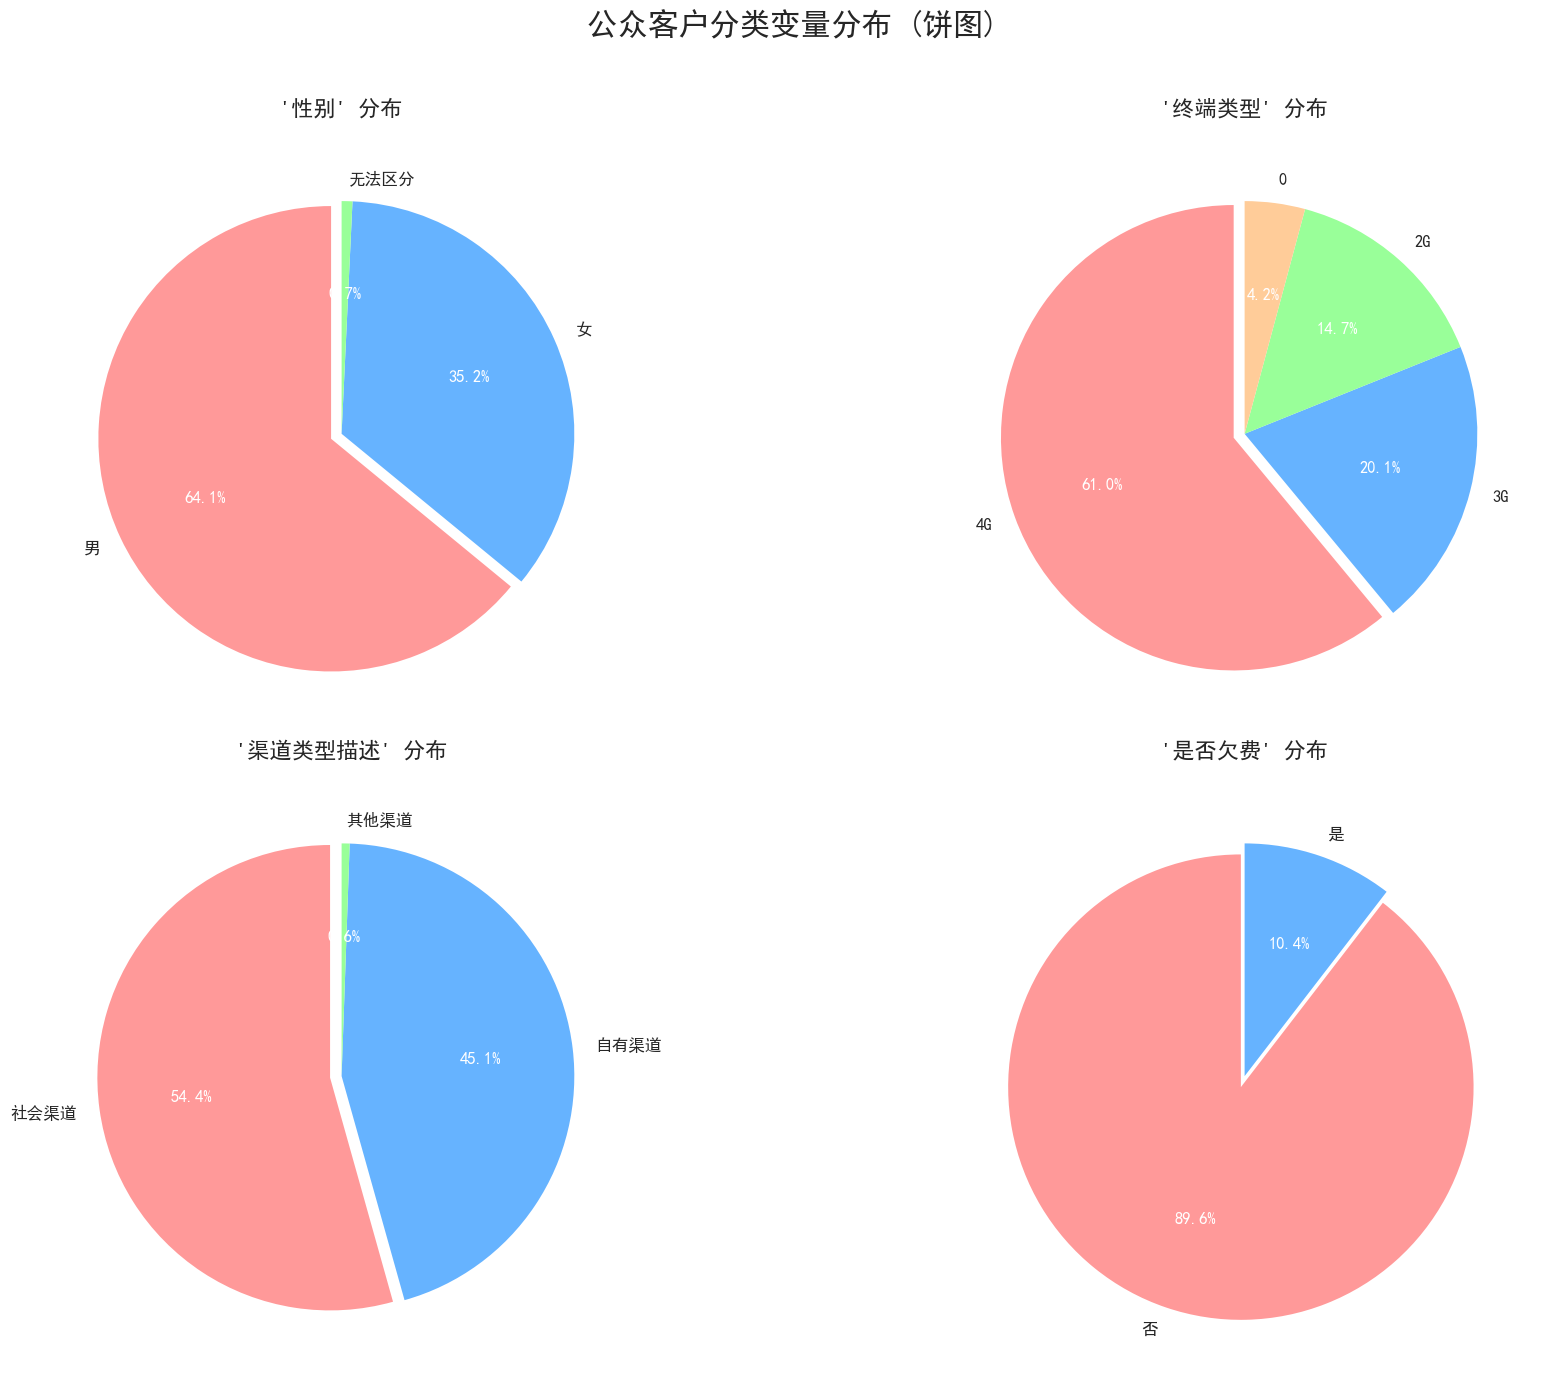

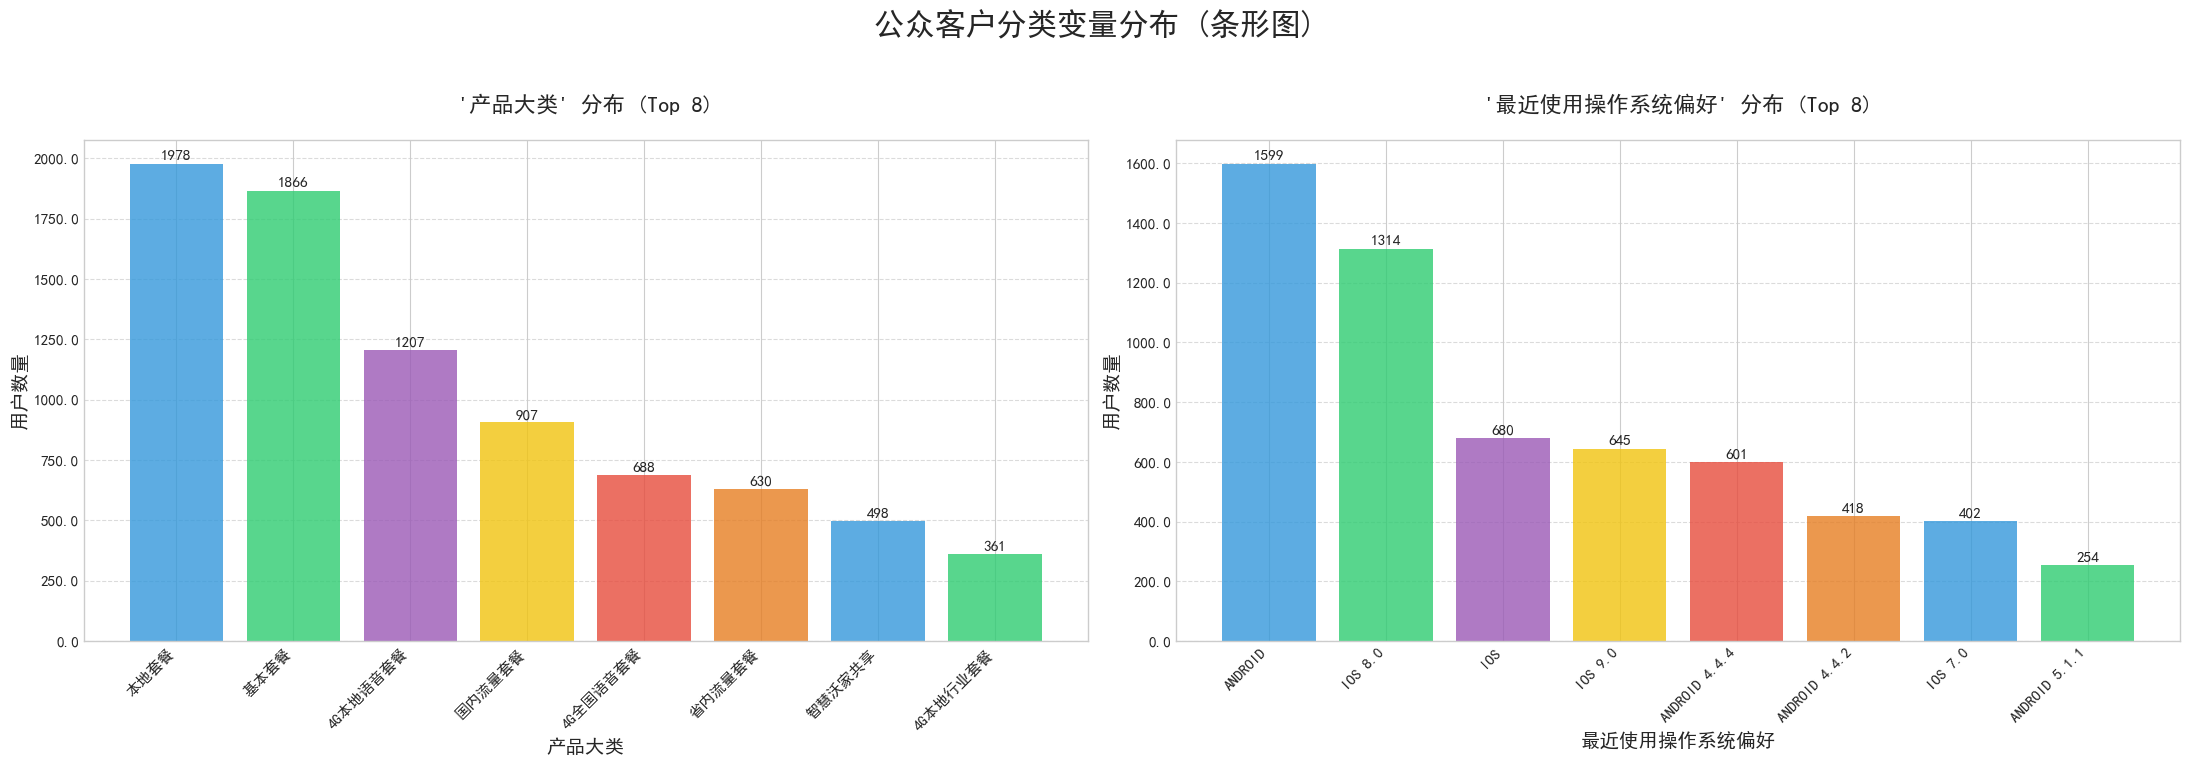

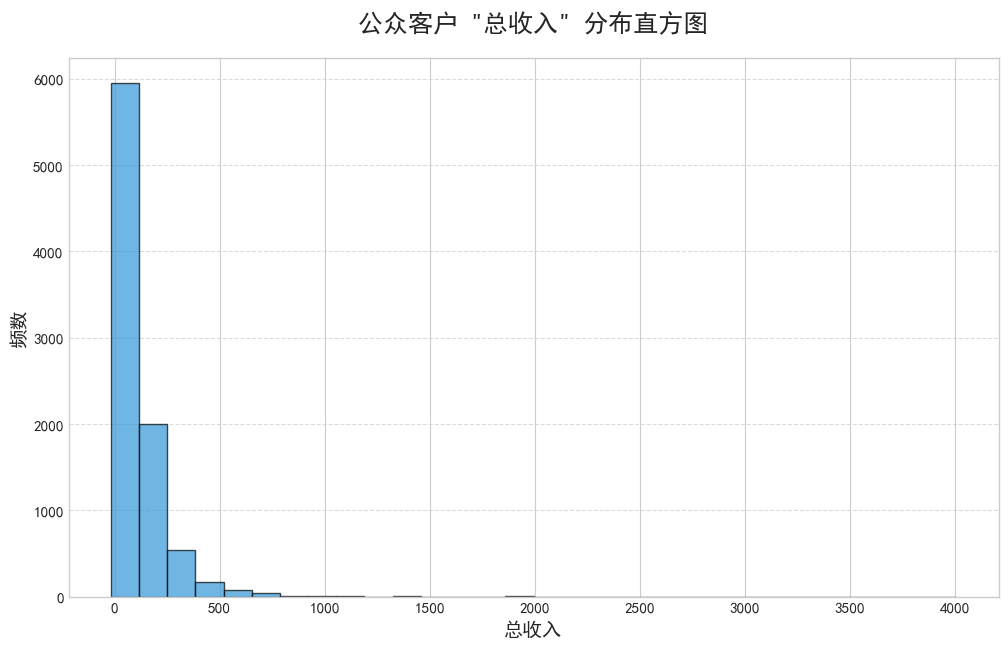

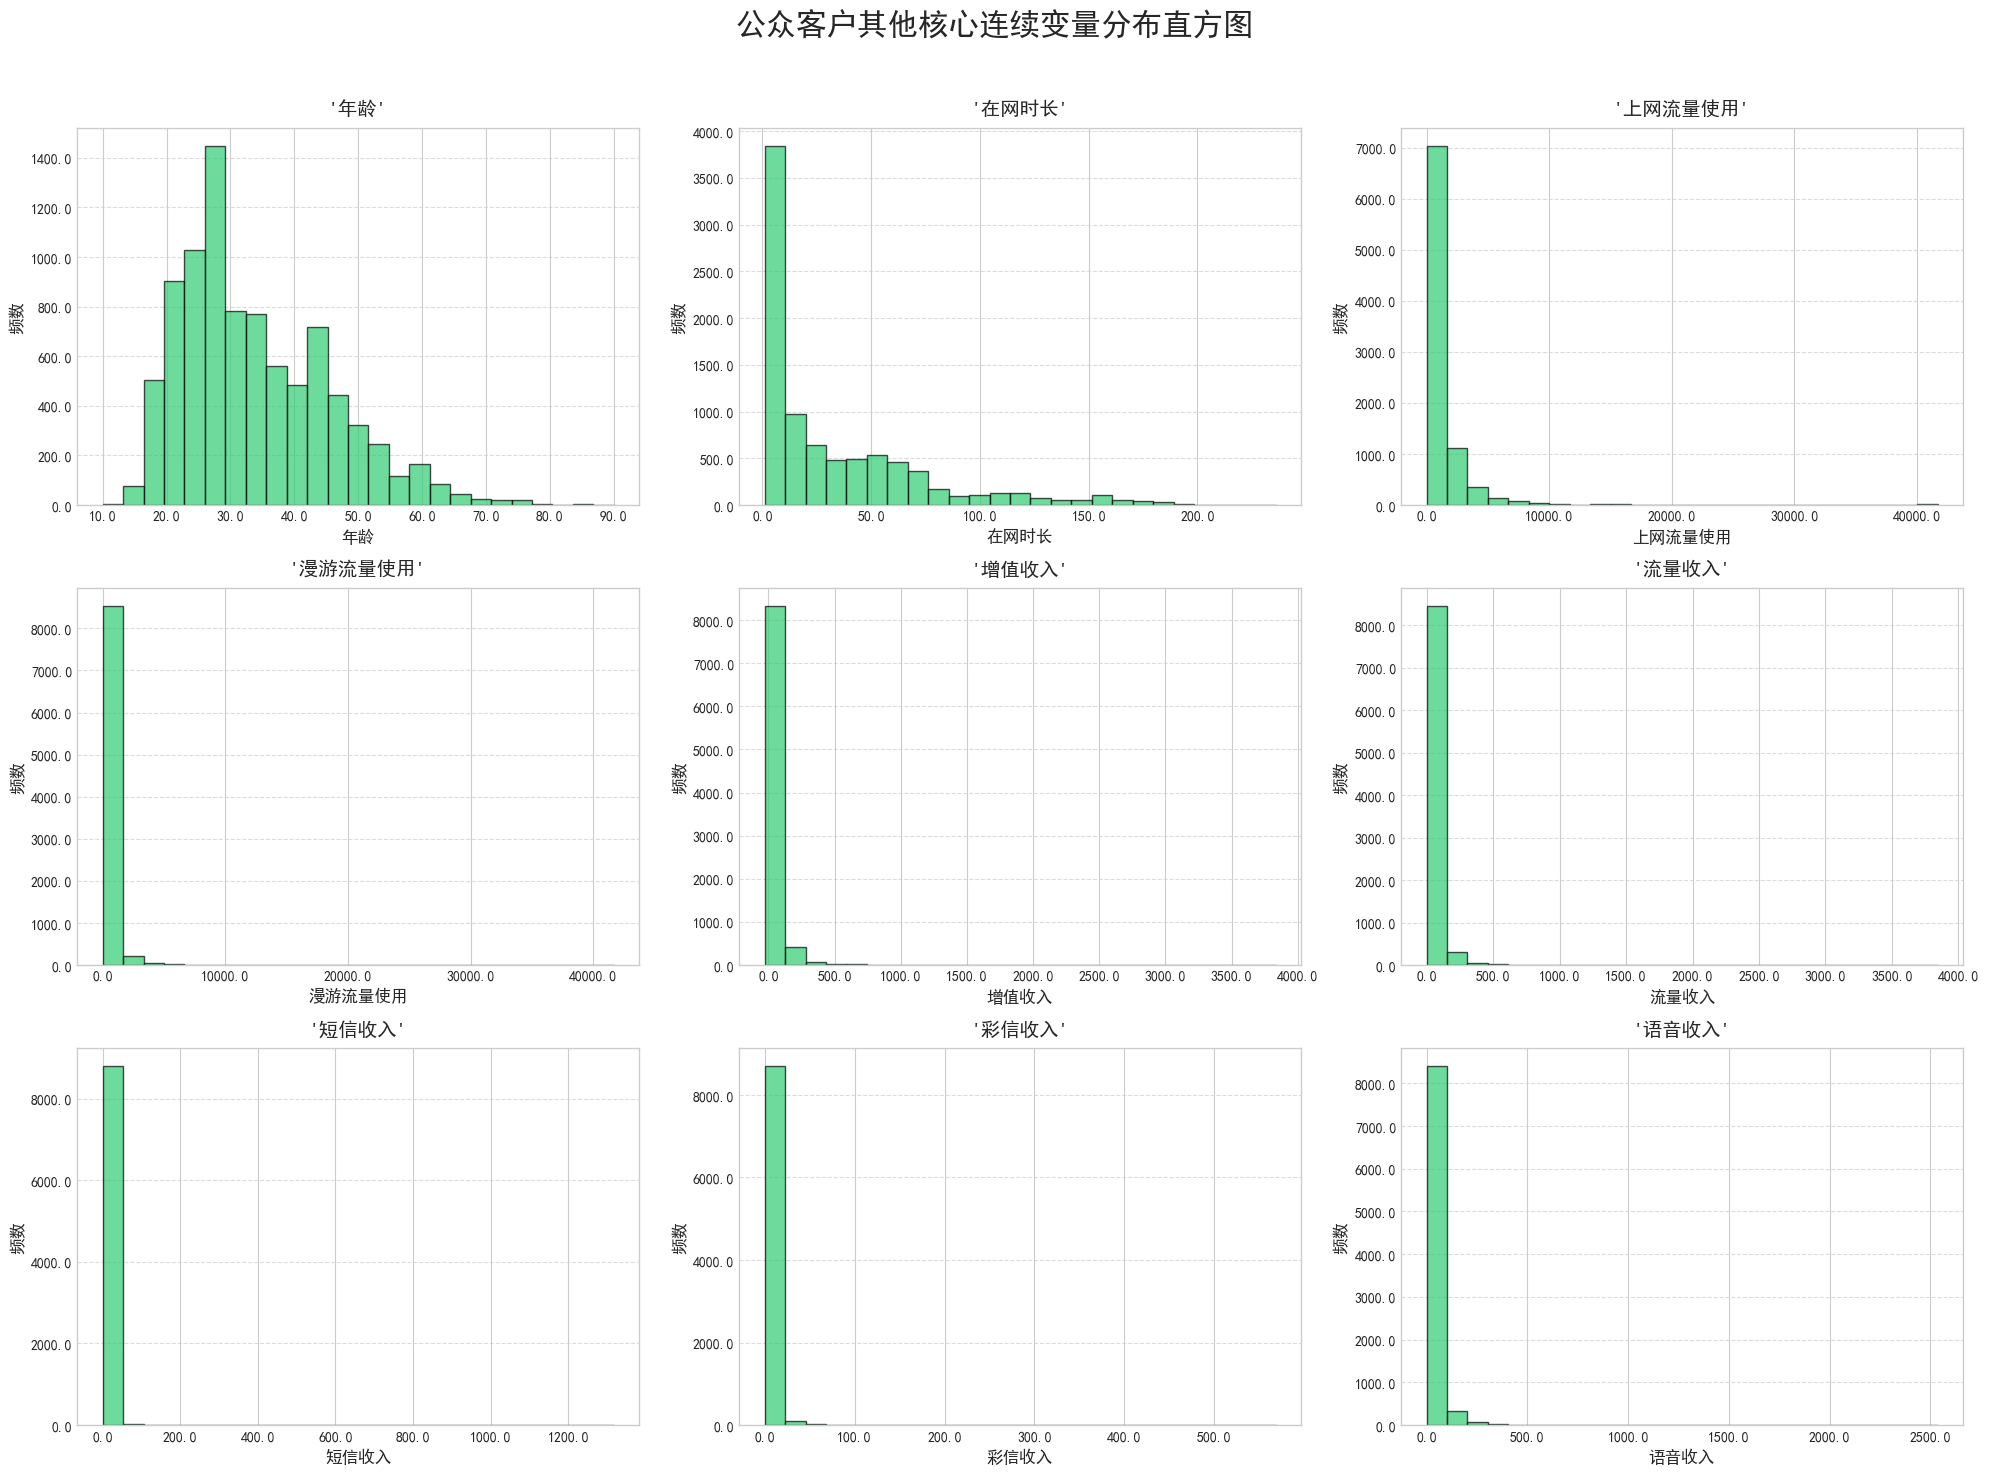


描述性统计与可视化完成。

[5] 公众客户中，目标相关变量的分布

(1) 是否欠费 分布（公众客户）
是否欠费
否    7921
是     924
Name: count, dtype: int64
占比(%)：
是否欠费
否    89.54
是    10.45
Name: count, dtype: float64

(2) 终端类型 分布（公众客户）
终端类型
4G    5395
3G    1775
2G    1302
0      370
Name: count, dtype: int64
占比(%)：
终端类型
4G    60.99
3G    20.07
2G    14.72
0      4.18
Name: count, dtype: float64

(3) 渠道类型描述 分布（公众客户）
渠道类型描述
社会渠道    4808
自有渠道    3988
其他渠道      49
Name: count, dtype: int64
占比(%)：
渠道类型描述
社会渠道    54.35
自有渠道    45.08
其他渠道     0.55
Name: count, dtype: float64

(4) 操作系统偏好（公众客户，原始取值 Top10）
最近使用操作系统偏好
ANDROID          1599
IOS 8.0          1314
IOS               680
IOS 9.0           645
ANDROID 4.4.4     601
ANDROID 4.4.2     418
IOS 7.0           402
ANDROID 5.1.1     254
ANDROID 4.3       253
ANDROID 5.0       248
Name: count, dtype: int64
占比(%)：
最近使用操作系统偏好
ANDROID          18.08
IOS 8.0          14.85
IOS               7.69
IOS 9.0           7.29
ANDROID 4.4.4     6.79
ANDROID 4.4.2     4.73
IOS 7.0           4.54
ANDROID 5

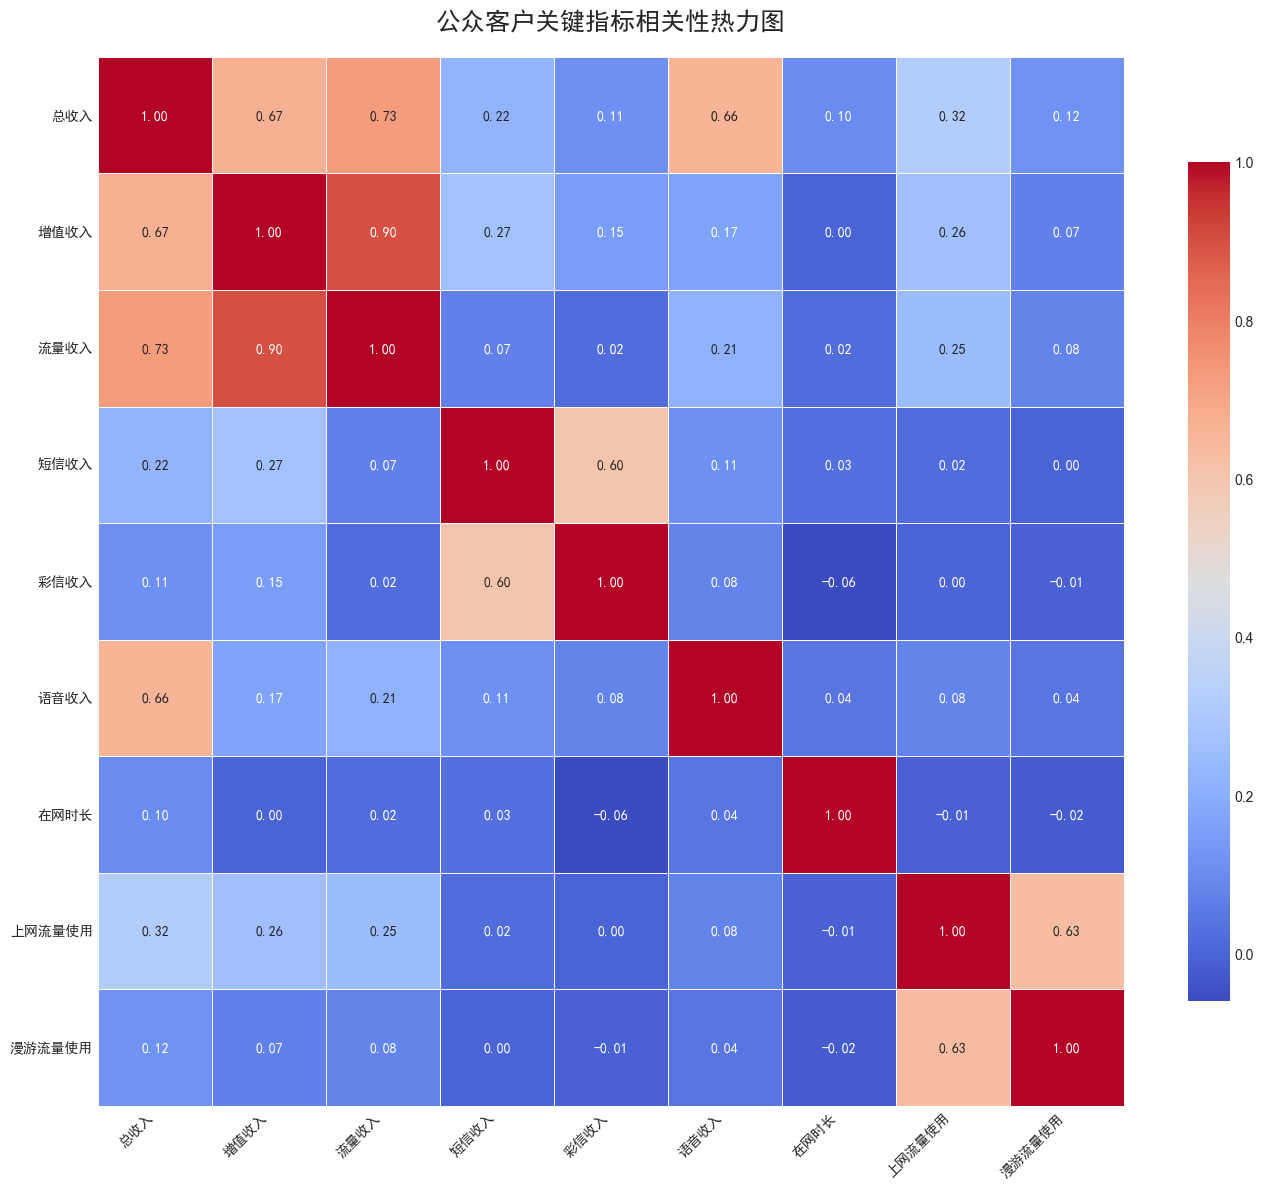


数据探索完成。后续所有建模任务统一使用 df_public。


In [3]:
# Step 1：加载 + 基础清洗
df = load_and_clean_telecom(df)
# Step 2：数据探索（全量 + 公众客户）
df_public = explore_telecom_data(df)

### **对df_public的补充分析** 

In [8]:
# 操作系统类型清洗
def simplify_os(x):
    if isinstance(x, str):
        xu = x.upper()
        if "ANDROID" in xu:
            return "ANDROID"
        if "IOS" in xu:
            return "IOS"
    return None

df5 = df_public.copy()
df5["最近使用操作系统偏好"] = df5["最近使用操作系统偏好"].apply(simplify_os)
df5 = df5[df5["最近使用操作系统偏好"].isin(["ANDROID", "IOS"])].copy()

# 1. 统计终端品牌和最近使用操作系统偏好的组合数据
brand_os_counts = df5.groupby(['终端品牌', '最近使用操作系统偏好']).size().sort_values(ascending=False)

# 2. 统计入网渠道类型和渠道类型描述的组合数据
channel_desc_counts = df5.groupby(['入网渠道类型', '渠道类型描述']).size().sort_values(ascending=False)

# 打印结果
print("终端品牌和最近使用操作系统偏好组合统计：")
print(brand_os_counts)
print("\n入网渠道类型和渠道类型描述组合统计：")
print(channel_desc_counts)

终端品牌和最近使用操作系统偏好组合统计：
终端品牌    最近使用操作系统偏好
苹果      IOS           3289
小米      ANDROID        866
三星      ANDROID        851
华为      ANDROID        803
维沃      ANDROID        431
                      ... 
锤子（作废）  ANDROID          1
飞利浦     ANDROID          1
骋娱传媒    ANDROID          1
鸿锦      ANDROID          1
黑莓      ANDROID          1
Length: 135, dtype: int64

入网渠道类型和渠道类型描述组合统计：
入网渠道类型  渠道类型描述
2.0     社会渠道      4210
1.0     自有渠道      3580
99.0    其他渠道        45
dtype: int64


### **任务1：使用线性回归模型和随机森林预测总收入**
汇报 2 个参数：**Root Mean Square Error（RMSE：均方根误差）**和**Mean Absolute Error（MAE：平均绝对误差）**，具体公式如下：

$$\text{RMSE} = \sqrt{\frac{1}{m}\sum_{i=1}^{m} (\widehat{y}_i - y_i)^2}$$

$$\text{MAE} = \frac{1}{m}\sum_{i=1}^{m} |\widehat{y}_i - y_i|$$

其中，$y_i$ 为第 $i$ 个样本的因变量的真实值，$\widehat{y}_i$ 为第 $i$ 个样本的因变量的预测值，$m$ 为测试集 (Testing Dataset) 的样本数。



任务1：预测总收入（回归任务）

警告：目标变量“总收入”存在1个缺失值，已用中位数（74.20）填充

【线性回归】

数值变量多重共线性（VIF）检测：
       变量       VIF
0      年龄  1.985794
1    在网时长  1.854073
2  上网流量使用  1.904400
3  漫游流量使用  1.701312

===== 系数与显著性（P值）TOP10 =====
                                                                      特征  \
产品分类_596元基本套餐（含国内语音3000分钟，国内流量11GB）  产品分类_596元基本套餐（含国内语音3000分钟，国内流量11GB）   
产品分类_296元基本套餐（含国内语音1000分钟，国内流量4GB)    产品分类_296元基本套餐（含国内语音1000分钟，国内流量4GB)   
产品分类_10元100MB国内流量套餐                                  产品分类_10元100MB国内流量套餐   
产品分类_20元300MB国内流量套餐                                  产品分类_20元300MB国内流量套餐   
产品分类_4G全国套餐-106元套餐（新）                              产品分类_4G全国套餐-106元套餐（新）   
产品分类_396元基本套餐（含国内语音2000分钟，国内流量6GB）    产品分类_396元基本套餐（含国内语音2000分钟，国内流量6GB）   
产品分类_4G主副卡业务-语音副卡基本套餐                              产品分类_4G主副卡业务-语音副卡基本套餐   
产品分类_196元基本套餐（含国内语音500分钟，国内流量3GB）      产品分类_196元基本套餐（含国内语音500分钟，国内流量3GB）   
产品大类_国内流量套餐                                                  产品大类_国内流量套餐   
上网流量使用                         

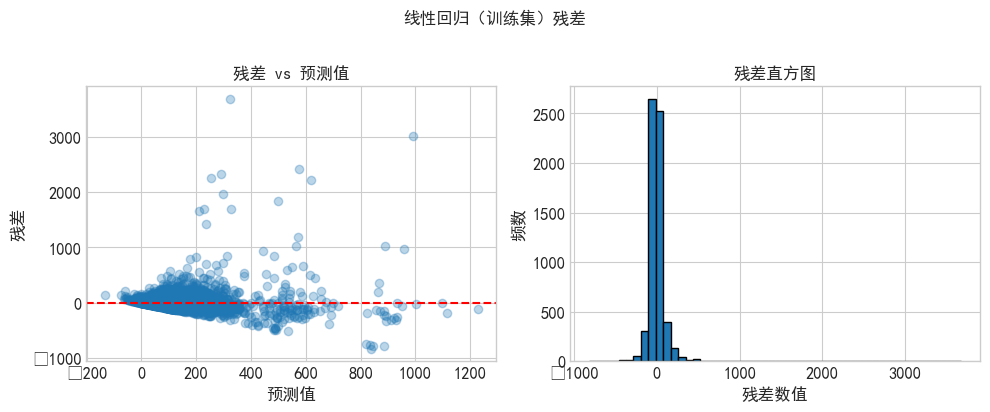

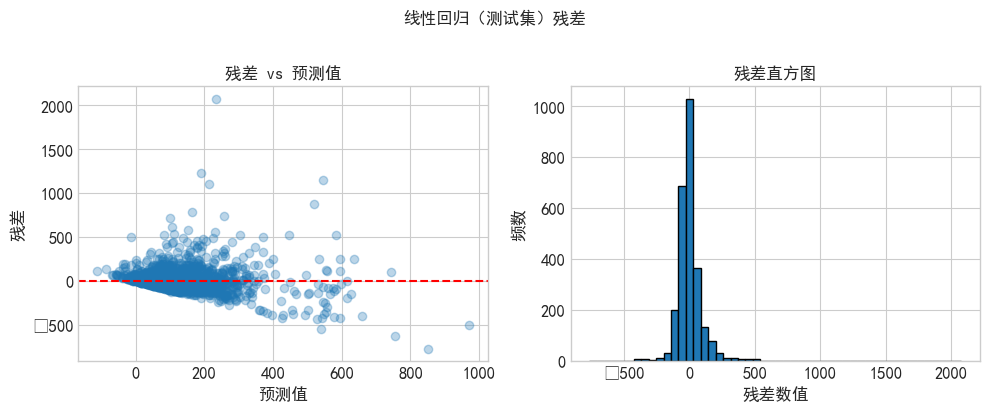

训练集 RMSE: 138.63，MAE: 61.50
测试集 RMSE: 117.40，MAE: 64.85

【随机森林（GridSearchCV调参）】
Fitting 3 folds for each of 48 candidates, totalling 144 fits

最佳参数： {'max_depth': 12, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
训练 RMSE: 81.70, MAE: 39.75
测试 RMSE: 104.89, MAE: 52.58

随机森林特征重要性 TOP5：
                                      特征       重要性
3                                 上网流量使用  0.283217
4                                 漫游流量使用  0.132042
357  产品分类_596元基本套餐（含国内语音3000分钟，国内流量11GB）  0.097006
1                                   在网时长  0.068570
0                                     年龄  0.065395

最终结论：随机森林 在测试集表现更好（RMSE 更低）


In [4]:
def task1_regression(df):
    print("\n" + "=" * 60)
    print("任务1：预测总收入（回归任务）")
    print("=" * 60)
    
    # 检查并处理目标变量缺失值（改用中位数填充）
    if df["总收入"].isnull().any():
        missing_count = df["总收入"].isnull().sum()
        # 计算中位数（使用整个数据集的中位数，更严谨的做法是用训练集中位数，此处简化处理）
        income_median = df["总收入"].median()
        print(f"\n警告：目标变量“总收入”存在{missing_count}个缺失值，已用中位数（{income_median:.2f}）填充")
        df = df.copy()  # 避免SettingWithCopyWarning
        df["总收入"] = df["总收入"].fillna(income_median)  # 中位数填充缺失值
    
    # 一、线性模型
    print("\n【线性回归】")
    import statsmodels.api as sm
    
    lr_exclude_cols = [
        "用户ID", "客户类型", 
        "增值收入", "流量收入", "短信收入", "彩信收入", "语音收入"
    ]

    y_lr = df["总收入"]  # 此时y_lr已无NaN
    X_lr = df.drop(columns=["总收入"] + lr_exclude_cols)

    # 缺失处理（特征变量）
    numeric_cols = X_lr.select_dtypes(include=[np.number]).columns
    object_cols  = X_lr.select_dtypes(include=["object"]).columns
    X_lr[numeric_cols] = X_lr[numeric_cols].fillna(X_lr[numeric_cols].median())
    X_lr[object_cols] = X_lr[object_cols].fillna("Unknown")
     
    # VIF检测
    print("\n数值变量多重共线性（VIF）检测：")
    vif_df = df[["年龄", "在网时长", "上网流量使用", "漫游流量使用"]].dropna()
    vif = pd.DataFrame({
        "变量": vif_df.columns,
        "VIF": [variance_inflation_factor(vif_df.values, i) 
                for i in range(vif_df.shape[1])]
    })
    print(vif)

    # One-hot编码（确保生成数值型 dummy 变量）
    X_lr = pd.get_dummies(X_lr, drop_first=True, dtype=np.int64)  # 显式指定dtype为int64
    
    # 关键修复1：强制转换所有列为float类型（statsmodels偏好float）
    X_lr = X_lr.astype(np.float64)
    
    # 关键修复2：添加常数项（确保常数项也是float类型）
    X_lr_sm = sm.add_constant(X_lr, has_constant='add')  # 显式添加常数项
    
    # 划分数据集（使用转换后的X_lr_sm）
    Xlr_train, Xlr_test, ylr_train, ylr_test = train_test_split(
        X_lr_sm, y_lr, test_size=0.3, random_state=42
    )
    
    # 关键修复3：确保目标变量是float类型
    ylr_train = ylr_train.astype(np.float64)
    ylr_test = ylr_test.astype(np.float64)
    
    # 使用 statsmodels 拟合线性回归（现在数据类型正确）
    lr_sm = sm.OLS(ylr_train, Xlr_train).fit()
    
    # # 输出详细结果（类似R的summary）
    # print("\n===== 线性回归模型详细统计结果 =====")
    # print(lr_sm.summary())
    
    # # 提取模型公式（类似 Y ~ X1 + X2 + ...）
    # print("\n===== 模型公式 =====")
    # features = X_lr.columns.tolist()
    # formula = f"总收入 ~ {' + '.join(features)}"
    # print(formula)
    
    # 提取系数和P值（按P值排序，查看显著性）
    print("\n===== 系数与显著性（P值）TOP10 =====")
    coef_p = pd.DataFrame({
        "特征": lr_sm.params.index,
        "系数": lr_sm.params.round(4),
        "P值": lr_sm.pvalues.round(4),
        "显著性": ["*" * min(3, sum([p < 0.1, p < 0.05, p < 0.01])) for p in lr_sm.pvalues]
    })
    # 排除常数项，按P值升序排列（最显著的在前）
    print(coef_p[coef_p["特征"] != "const"].sort_values("P值").head(10))
    
    # 训练集预测
    lr_pred_train = lr_sm.predict(Xlr_train)
    lr_rmse_train = mean_squared_error(ylr_train, lr_pred_train) ** 0.5
    lr_mae_train  = mean_absolute_error(ylr_train, lr_pred_train)
    
    # 测试集预测
    lr_pred_test = lr_sm.predict(Xlr_test)
    lr_rmse_test = mean_squared_error(ylr_test, lr_pred_test) ** 0.5
    lr_mae_test  = mean_absolute_error(ylr_test, lr_pred_test)

    # 残差分析（修复中文显示）
    def plot_residuals(y_true, y_pred, title="线性模型残差诊断"):
        # 加载中文字体（与之前保持一致的字体逻辑）
        from matplotlib.font_manager import FontProperties
        font = None
        try:
            font = FontProperties(family='SimHei', size=12)  # 优先使用SimHei
        except Exception:
            fallback_fonts = ['Microsoft YaHei', 'DengXian', 'WenQuanYi Micro Hei']
            for font_name in fallback_fonts:
                try:
                    font = FontProperties(family=font_name, size=12)
                    break
                except Exception:
                    continue
        
        residuals = y_true - y_pred
        plt.figure(figsize=(10, 4))
    
        # 子图1：残差 vs 预测值
        plt.subplot(1, 2, 1)
        plt.scatter(y_pred, residuals, alpha=0.3)
        plt.axhline(0, color="red", linestyle="--")
        # 为标题指定字体
        plt.title("残差 vs 预测值", fontproperties=font)
        # 为坐标轴标签指定字体（如果有需要）
        plt.xlabel("预测值", fontproperties=font)
        plt.ylabel("残差", fontproperties=font)
        # 为坐标轴刻度指定字体
        plt.xticks(fontproperties=font)
        plt.yticks(fontproperties=font)
    
        # 子图2：残差直方图
        plt.subplot(1, 2, 2)
        plt.hist(residuals, bins=50, edgecolor="black")
        # 为标题指定字体
        plt.title("残差直方图", fontproperties=font)
        # 为坐标轴标签指定字体（如果有需要）
        plt.xlabel("残差数值", fontproperties=font)
        plt.ylabel("频数", fontproperties=font)
        # 为坐标轴刻度指定字体
        plt.xticks(fontproperties=font)
        plt.yticks(fontproperties=font)
    
        # 总标题指定字体
        plt.suptitle(title, fontproperties=font, y=1.02)  # y=1.02避免总标题与子图标题重叠
        plt.tight_layout()
        plt.show()

    plot_residuals(ylr_train, lr_pred_train, "线性回归（训练集）残差")
    plot_residuals(ylr_test,  lr_pred_test,  "线性回归（测试集）残差")

    print(f"训练集 RMSE: {lr_rmse_train:.2f}，MAE: {lr_mae_train:.2f}")
    print(f"测试集 RMSE: {lr_rmse_test:.2f}，MAE: {lr_mae_test:.2f}")

    # 二、随机森林：使用GridSearchCV网格搜索
    print("\n【随机森林（GridSearchCV调参）】")
    
    rf_exclude_cols = ["用户ID", "客户类型", "增值收入", "流量收入", "短信收入", "彩信收入", "语音收入"] 
    
    y_rf = df["总收入"]
    X_rf = df.drop(columns=["总收入"] + rf_exclude_cols)
    
    # 缺失处理（特征变量）
    num_cols_rf = X_rf.select_dtypes(include=[np.number]).columns
    obj_cols_rf = X_rf.select_dtypes(include=["object"]).columns
    X_rf[num_cols_rf] = X_rf[num_cols_rf].fillna(X_rf[num_cols_rf].median())
    X_rf[obj_cols_rf] = X_rf[obj_cols_rf].fillna("Unknown")
    
    # one-hot编码
    X_rf = pd.get_dummies(X_rf, drop_first=True)
    
    # 划分数据集
    Xrf_train, Xrf_test, yrf_train, yrf_test = train_test_split(
        X_rf, y_rf, test_size=0.3, random_state=42
    )
    
    # ---- 网格搜索调参（GridSearchCV）----
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import GridSearchCV  # 改为网格搜索
    
    # 精简参数范围（避免组合数过多导致计算量爆炸）
    param_grid = {
        "n_estimators": [200, 300],  # 比原来少1个选项
        "max_depth": [8, 10, 12],    # 比原来少2个选项
        "min_samples_split": [2, 5], # 比原来少2个选项
        "min_samples_leaf": [1, 2],  # 比原来少3个选项
        "max_features": ["sqrt", 0.5] # 比原来少2个选项
    }
    # 总组合数：2×3×2×2×2 = 48组（原随机搜索是20组，计算量增加但可控）
    
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    
    # 替换为GridSearchCV，删除n_iter参数（网格搜索会遍历所有组合）
    search = GridSearchCV(
        rf, param_grid=param_grid,  # 参数名从param_distributions改为param_grid
        scoring="neg_mean_squared_error",
        cv=3, n_jobs=-1, verbose=1  # verbose=1显示调参进度
    )
    search.fit(Xrf_train, yrf_train)
    
    best_rf = search.best_estimator_
    print("\n最佳参数：", search.best_params_)
    
    # 训练集预测
    rf_pred_train = best_rf.predict(Xrf_train)
    rf_rmse_train = mean_squared_error(yrf_train, rf_pred_train) **0.5
    rf_mae_train  = mean_absolute_error(yrf_train, rf_pred_train)
    
    # 测试集预测
    rf_pred_test = best_rf.predict(Xrf_test)
    rf_rmse_test = mean_squared_error(yrf_test, rf_pred_test)** 0.5
    rf_mae_test  = mean_absolute_error(yrf_test, rf_pred_test)
    
    print(f"训练 RMSE: {rf_rmse_train:.2f}, MAE: {rf_mae_train:.2f}")
    print(f"测试 RMSE: {rf_rmse_test:.2f}, MAE: {rf_mae_test:.2f}")
    
    # 特征重要性
    print("\n随机森林特征重要性 TOP5：")
    fi = (
        pd.DataFrame({"特征": X_rf.columns, "重要性": best_rf.feature_importances_})
        .sort_values("重要性", ascending=False)
        .head(5)
    )
    print(fi)
    
    # 对比结论
    better = "随机森林" if rf_rmse_test < lr_rmse_test else "线性回归"
    print(f"\n最终结论：{better} 在测试集表现更好（RMSE 更低）")

task1_regression(df_public)

### **任务2-5：分类**
1) 任意选择下面几种分类算法中的3 个进行分类：`a)随机森林；b)朴素贝叶斯；c)神经网络；d）最近邻分类；e)逻辑回归；f）支持向量机；g）XGBoost`。
2) 对任务2-5，根据选择的**3个**分类模型（不同任务选择的模型可以不同）分别汇报：
   - 混淆矩阵，
   - 预测准确度/精度，
   - Precision（查准率）,
   - Recall（查全率）。  
**对3个模型中的至少一个模型，汇报ROC曲线**。
3) 根据以上指标分析哪个模型的分类效果最好，并**解释可能的原因**。


任务2：预测是否欠费（严重不平衡二分类）
有效样本数量： 8845
Fitting 3 folds for each of 81 candidates, totalling 243 fits
随机森林阶段1最优参数：{'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 200}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
随机森林阶段2最优参数：{'bootstrap': True, 'max_features': 'sqrt', 'oob_score': True}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost阶段1最优树结构参数：{'gamma': 0.2, 'max_depth': 4, 'min_child_weight': 5}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
XGBoost阶段2最优抽样参数：{'colsample_bytree': 0.8, 'subsample': 0.8}

---- LogisticRegression ----
Accuracy : 0.6642
Precision: 0.1800
Recall   : 0.6216
F1-score : 0.2791
ROC-AUC  : 0.6899

混淆矩阵：
[[1060  524]
 [  70  115]]

---- RandomForest ----
Accuracy : 0.8677
Precision: 0.3600
Recall   : 0.3405
F1-score : 0.3500
ROC-AUC  : 0.7470

混淆矩阵：
[[1472  112]
 [ 122   63]]

---- XGBoost ----
Accuracy : 0.8282
Precision: 0.2912
Recall   : 0.4486
F1-score : 0.3532
ROC-AUC  : 0.7548

混淆矩

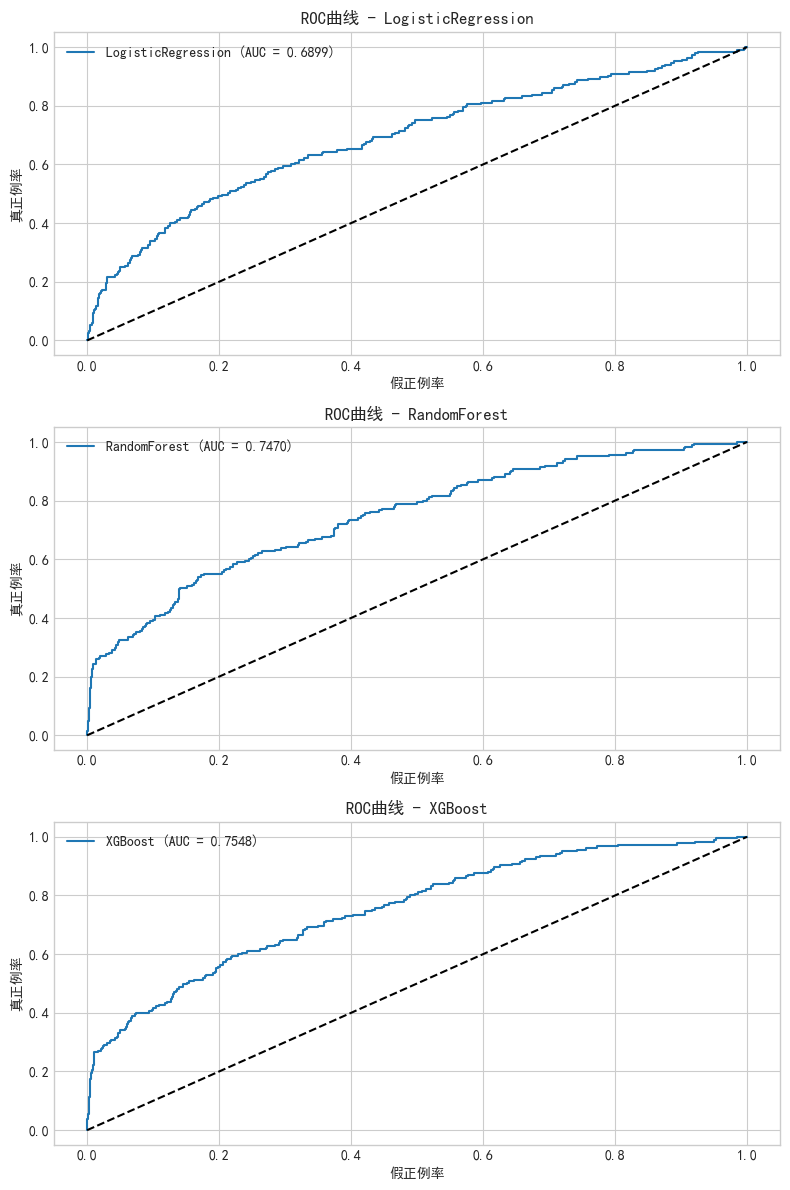



===== 三模型对比（任务2）=====
                    Accuracy  Precision    Recall        F1   ROC-AUC
XGBoost             0.828151   0.291228  0.448649  0.353191  0.754784
RandomForest        0.867722   0.360000  0.340541  0.350000  0.747048
LogisticRegression  0.664217   0.179969  0.621622  0.279126  0.689882

任务3：预测终端类型（2G / 3G / 4G）
有效样本数： 8472
Fitting 3 folds for each of 81 candidates, totalling 243 fits
随机森林阶段1最优参数：{'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 150}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
随机森林阶段2最优参数：{'bootstrap': True, 'max_features': 'sqrt', 'oob_score': True}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost阶段1最优树结构参数：{'gamma': 0, 'max_depth': 4, 'min_child_weight': 5}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
XGBoost阶段2最优抽样参数：{'colsample_bytree': 0.8, 'subsample': 0.8}

MultinomialLogit
Accuracy : 0.6867
Macro-F1 : 0.4460
混淆矩阵：
[[ 122    0  139]
 [  42    0  313]
 [  37    0 104

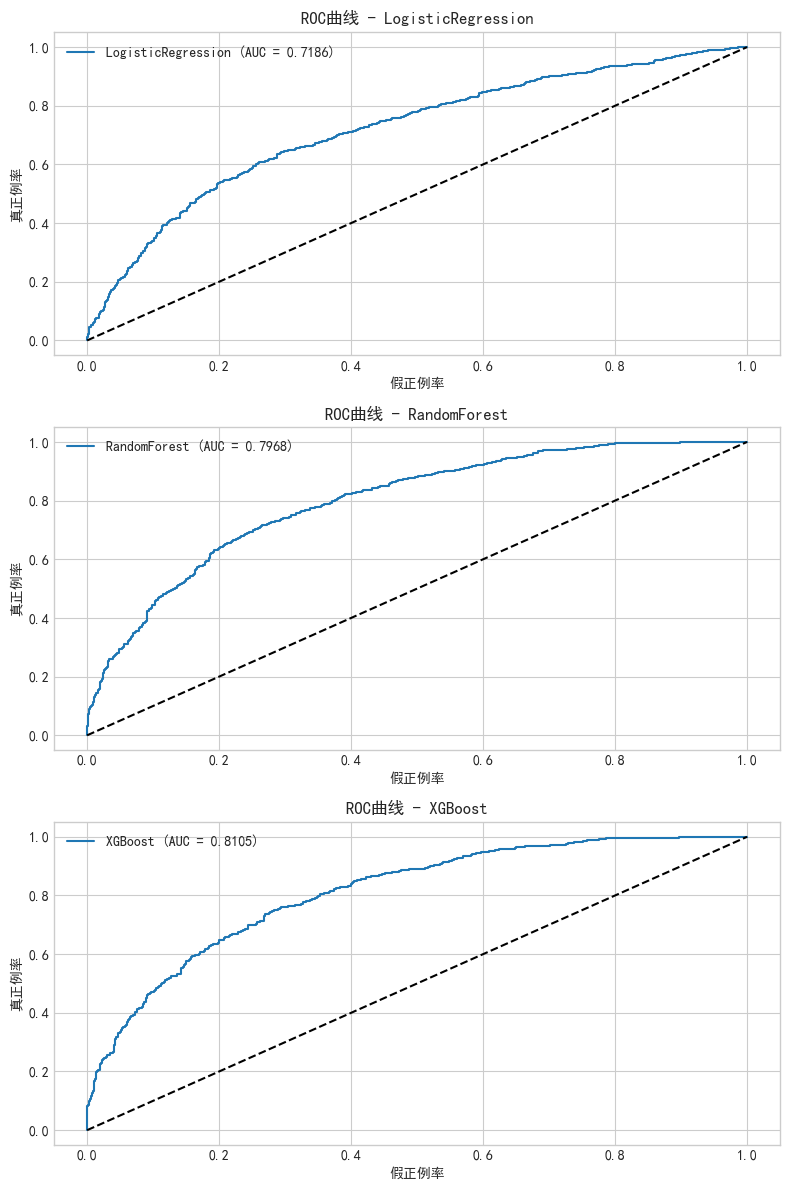



===== 三模型对比（任务4）=====
                    Accuracy  Precision    Recall        F1   ROC-AUC
XGBoost             0.722727   0.774306  0.695426  0.732749  0.810502
RandomForest        0.723864   0.741870  0.758836  0.750257  0.796843
LogisticRegression  0.656250   0.663014  0.754678  0.705882  0.718604

任务5：预测操作系统偏好（ANDROID vs IOS）
有效样本数： 7836
Fitting 3 folds for each of 81 candidates, totalling 243 fits
随机森林阶段1最优参数：{'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 250}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
随机森林阶段2最优参数：{'bootstrap': True, 'max_features': 'sqrt', 'oob_score': True}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost阶段1最优树结构参数：{'gamma': 0.2, 'max_depth': 3, 'min_child_weight': 1}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
XGBoost阶段2最优抽样参数：{'colsample_bytree': 0.8, 'subsample': 0.8}

---- LogisticRegression ----
Accuracy : 0.6888
Precision: 0.6847
Recall   : 0.4810
F1-score : 0.5651
ROC

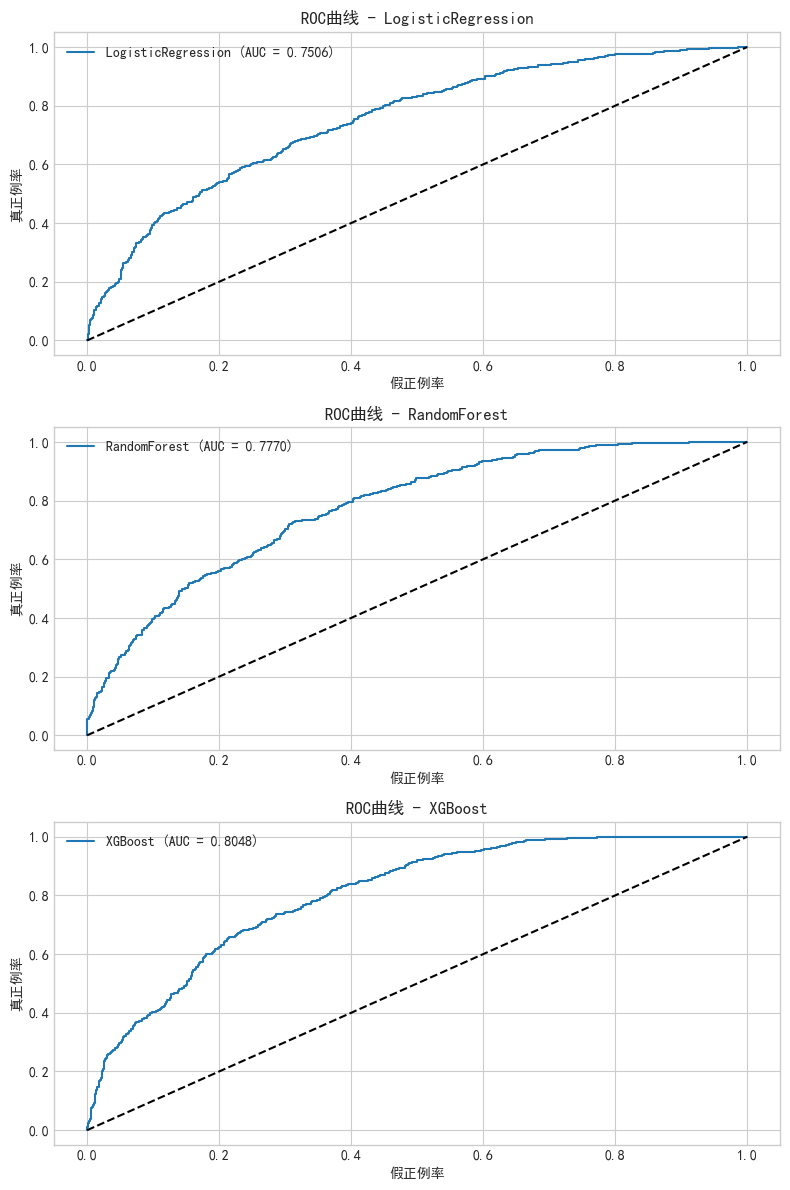



===== 三模型对比（任务5）=====
                    Accuracy  Precision    Recall        F1   ROC-AUC
XGBoost             0.727679   0.680685  0.663126  0.671791  0.804778
RandomForest        0.703444   0.627297  0.725341  0.672766  0.776970
LogisticRegression  0.688776   0.684665  0.481032  0.565062  0.750607


In [5]:
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report, roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# 全局中文显示设置
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False


# 随机森林网格搜索（不变）
def rf_grid_search(X_train, y_train, is_multiclass=False):
    scoring = "f1_macro" if is_multiclass else "f1"
    
    param_grid_stage1 = {
        "n_estimators": [150, 200, 250],
        "max_depth": [8, 10, 12],
        "min_samples_split": [8, 10, 12],
        "min_samples_leaf": [3, 4, 5]
    }
    
    rf_stage1 = RandomForestClassifier(
        class_weight="balanced" if not is_multiclass else "balanced_subsample",
        n_jobs=-1,
        random_state=42
    )
    
    grid_stage1 = GridSearchCV(
        estimator=rf_stage1,
        param_grid=param_grid_stage1,
        cv=3,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )
    grid_stage1.fit(X_train, y_train)
    best_params1 = grid_stage1.best_params_
    print(f"随机森林阶段1最优参数：{best_params1}")
    
    param_grid_stage2 = {
        "max_features": ["sqrt", "log2"],
        "bootstrap": [True, False],
        "oob_score": [True] if best_params1.get("bootstrap", True) else [False]
    }
    
    rf_stage2 = RandomForestClassifier(
        **best_params1,
        class_weight="balanced" if not is_multiclass else "balanced_subsample",
        n_jobs=-1,
        random_state=42
    )
    
    grid_stage2 = GridSearchCV(
        estimator=rf_stage2,
        param_grid=param_grid_stage2,
        cv=3,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )
    grid_stage2.fit(X_train, y_train)
    print(f"随机森林阶段2最优参数：{grid_stage2.best_params_}")
    
    return grid_stage2.best_estimator_


# XGBoost 网格搜索（移除早停参数，兼容旧版本）
def xgb_grid_search(X_train, y_train, is_multiclass=False, num_classes=None):
    scoring = "f1_macro" if is_multiclass else "f1"
    objective = "multi:softprob" if is_multiclass else "binary:logistic"
    eval_metric = "mlogloss" if is_multiclass else "logloss"
    
    if not is_multiclass:
        neg_pos_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
    else:
        neg_pos_ratio = 1
    
    # 阶段1：搜索树结构参数（移除早停）
    param_grid_stage1 = {
        "max_depth": [3, 4, 5],
        "min_child_weight": [1, 3, 5],
        "gamma": [0, 0.1, 0.2]
    }
    
    xgb_stage1 = XGBClassifier(
        objective=objective,
        num_class=num_classes if is_multiclass else None,
        learning_rate=0.3,
        n_estimators=300,  # 固定迭代次数，不使用早停
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=neg_pos_ratio * 0.8 if not is_multiclass else None,
        eval_metric=eval_metric,
        n_jobs=-1,
        random_state=42
    )
    
    grid_stage1 = GridSearchCV(
        estimator=xgb_stage1,
        param_grid=param_grid_stage1,
        cv=3,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )
    grid_stage1.fit(X_train, y_train)  # 不传递早停参数
    best_params1 = grid_stage1.best_params_
    print(f"XGBoost阶段1最优树结构参数：{best_params1}")
    
    # 阶段2：搜索抽样参数（移除早停）
    param_grid_stage2 = {
        "subsample": [0.7, 0.8, 0.9],
        "colsample_bytree": [0.7, 0.8, 0.9]
    }
    
    xgb_stage2 = XGBClassifier(
        **best_params1,
        objective=objective,
        num_class=num_classes if is_multiclass else None,
        learning_rate=0.3,
        n_estimators=300,
        scale_pos_weight=neg_pos_ratio * 0.8 if not is_multiclass else None,
        eval_metric=eval_metric,
        n_jobs=-1,
        random_state=42
    )
    
    grid_stage2 = GridSearchCV(
        estimator=xgb_stage2,
        param_grid=param_grid_stage2,
        cv=3,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )
    grid_stage2.fit(X_train, y_train)  # 不传递早停参数
    best_params2 = grid_stage2.best_params_
    print(f"XGBoost阶段2最优抽样参数：{best_params2}")
    
    # 最终模型（固定迭代次数）
    xgb_final = XGBClassifier(
        **best_params1,** best_params2,
        objective=objective,
        num_class=num_classes if is_multiclass else None,
        learning_rate=0.01,
        n_estimators=1500,  # 固定较多的迭代次数
        scale_pos_weight=neg_pos_ratio * 0.8 if not is_multiclass else None,
        eval_metric=eval_metric,
        n_jobs=-1,
        random_state=42
    )
    xgb_final.fit(X_train, y_train)
    
    return xgb_final


# 特征预处理函数（不变）
def preprocess_features(df, target_col, drop_cols):
    X = df.drop(columns=[target_col] + drop_cols)
    y = df[target_col]
    
    num_cols = X.select_dtypes(include=[np.number]).columns
    cat_cols = X.select_dtypes(include=["object"]).columns
    
    X[num_cols] = X[num_cols].fillna(X[num_cols].median())
    X[cat_cols] = X[cat_cols].fillna("Unknown")
    
    for col in cat_cols:
        freq = X[col].value_counts(normalize=True)
        low_freq = freq[freq < 0.01].index
        X[col] = X[col].replace(low_freq, "Other")
    
    X = pd.get_dummies(X, drop_first=True, dtype=np.int64)
    return X, y, X.columns


# 任务2（修改XGBoost调用方式，不需要验证集）
def task2_predict_arrears(df_public):
    print("\n" + "="*60)
    print("任务2：预测是否欠费（严重不平衡二分类）")
    print("="*60)

    df2 = df_public[df_public["是否欠费"].isin(["是","否"])].copy()
    print("有效样本数量：", df2.shape[0])

    num_cols = ["总收入", "增值收入", "流量收入", "短信收入", "彩信收入", "语音收入"]
    for col in num_cols:
        df2[col] = df2[col].clip(lower=0)

    df2["流量收入占比"] = df2["流量收入"] / (df2["总收入"] + 1e-6)
    df2["在网时长_收入比"] = df2["在网时长"] / (df2["总收入"] + 1e-6)

    target = "是否欠费"
    drop_cols = ["用户ID", "客户类型", "入网渠道类型"]

    y = df2[target].map({"是":1, "否":0})
    X = df2.drop(columns=[target] + drop_cols)

    num_cols = X.select_dtypes(include=[np.number]).columns
    cat_cols = X.select_dtypes(include=["object"]).columns

    X["年龄"] = X["年龄"].fillna(X["年龄"].mean())
    X[num_cols.drop("年龄")] = X[num_cols.drop("年龄")].fillna(X[num_cols.drop("年龄")].median())
    X[cat_cols] = X[cat_cols].fillna("Unknown")

    for col in cat_cols:
        freq = X[col].value_counts(normalize=True)
        low_freq = freq[freq < 0.01].index
        X[col] = X[col].replace(low_freq, "Other")

    X = pd.get_dummies(X, drop_first=True, dtype=np.int64)

    # 只划分训练集和测试集（不需要验证集）
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 模型定义（XGBoost不需要传递验证集）
    models = {
        "LogisticRegression": LogisticRegression(
            C=0.1,
            max_iter=500,
            class_weight="balanced",
            n_jobs=-1
        ),
        "RandomForest": rf_grid_search(X_train, y_train, is_multiclass=False),
        "XGBoost": xgb_grid_search(X_train, y_train, is_multiclass=False)  # 移除验证集参数
    }

    results = {}
    roc_data = {}

    for name, model in models.items():
        print(f"\n---- {name} ----")
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        proba = model.predict_proba(X_test)[:,1]

        fpr, tpr, _ = roc_curve(y_test, proba)
        roc_data[name] = (fpr, tpr)

        acc = accuracy_score(y_test, pred)
        prec = precision_score(y_test, pred)
        rec = recall_score(y_test, pred)
        f1 = f1_score(y_test, pred)
        auc = roc_auc_score(y_test, proba)

        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1-score : {f1:.4f}")
        print(f"ROC-AUC  : {auc:.4f}")
        print("\n混淆矩阵：")
        print(confusion_matrix(y_test, pred))

        results[name] = [acc, prec, rec, f1, auc]
        joblib.dump(model, f"task2_{name.lower()}_best_model.pkl")

    plt.figure(figsize=(8, 12))
    for i, (name, (fpr, tpr)) in enumerate(roc_data.items(), 1):
        plt.subplot(3, 1, i)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name][4]:.4f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("假正例率")
        plt.ylabel("真正例率")
        plt.title(f"ROC曲线 - {name}")
        plt.legend()
    plt.tight_layout()
    plt.show()

    res_df = pd.DataFrame(
        results,
        index=["Accuracy","Precision","Recall","F1","ROC-AUC"]
    ).T
    print("\n\n===== 三模型对比（任务2）=====")
    print(res_df.sort_values("ROC-AUC", ascending=False))

    return res_df


# 任务3（同理修改，移除验证集和早停）
def task3_terminal_type(df_public):
    print("\n" + "=" * 60)
    print("任务3：预测终端类型（2G / 3G / 4G）")
    print("=" * 60)
    
    df3 = df_public[df_public["终端类型"].isin(["2G", "3G", "4G"])].copy()
    print("有效样本数：", df3.shape[0])

    df3["单位流量成本"] = df3["流量收入"] / (df3["上网流量使用"] + 1e-6)
    df3["在网时长分箱"] = pd.cut(
        df3["在网时长"], 
        bins=[0, 12, 36, 1000], 
        labels=["1年以内", "1-3年", "3年以上"]
    )

    drop_cols = ["用户ID", "客户类型", "最近使用操作系统偏好"]
    X, y, _ = preprocess_features(df3, target_col="终端类型", drop_cols=drop_cols)
    y = y.map({"2G": 0, "3G": 1, "4G": 2})
    num_classes = y.nunique()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    models = {
        "MultinomialLogit": LogisticRegression(
            C=0.5,
            max_iter=500,
            multi_class="multinomial",
            n_jobs=-1
        ),
        "RandomForest": rf_grid_search(X_train, y_train, is_multiclass=True),
        "XGBoost": xgb_grid_search(
            X_train, y_train, 
            is_multiclass=True, 
            num_classes=num_classes
        )
    }

    results = {}
    
    # 关键：将多分类标签转为二进制（one-hot）格式，用于OVR策略
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # 3类对应3列二进制标签
    n_classes = y_test_bin.shape[1]  # 类别数=3
    
    for name, model in models.items():
        print(f"\n{name}")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # 新增：获取每个类别的预测概率（需模型支持predict_proba方法）
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)  # 形状为(n_samples, n_classes)
        else:
            # 若模型不支持概率输出（如部分简化模型），可跳过或用决策分数
            print(f"{name}不支持概率输出，无法计算ROC-AUC")
            continue
        
        # 计算每个类别的AUC（OVR策略）
        auc_scores = {}
        for i in range(n_classes):
            auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])
            auc_scores[f"类别{i}（{['2G','3G','4G'][i]}）AUC"] = auc
        
        # 计算平均AUC（macro：算术平均，micro：全局平均）
        macro_auc = roc_auc_score(y_test_bin, y_score, average="macro")
        micro_auc = roc_auc_score(y_test_bin, y_score, average="micro")
        auc_scores["macro-AUC（整体）"] = macro_auc
        auc_scores["micro-AUC（整体）"] = micro_auc
        
        # 打印AUC结果
        print("\nAUC分数（One-vs-Rest策略）：")
        for key, value in auc_scores.items():
            print(f"{key}: {value:.4f}")
        
        # 绘制ROC曲线（每个类别一条曲线）
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            plt.plot(fpr, tpr, lw=2, label=f"类别{['2G','3G','4G'][i]} (AUC = {auc_scores[f'类别{i}（{['2G','3G','4G'][i]}）AUC']:.4f})")
        
        # 绘制随机猜测的基准线（AUC=0.5）
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('假正例率（FPR）')
        plt.ylabel('真正例率（TPR）')
        plt.title(f'{name}的ROC曲线（多分类OVR策略）')
        plt.legend(loc="lower right")
        plt.show()
        
        acc = accuracy_score(y_test, y_pred)
        f1m = f1_score(y_test, y_pred, average="macro")

        print(f"Accuracy : {acc:.4f}")
        print(f"Macro-F1 : {f1m:.4f}")
        print("混淆矩阵：")
        print(confusion_matrix(y_test, y_pred))
        print("分类报告：")
        print(classification_report(y_test, y_pred))

        results[name] = [acc, f1m]
        joblib.dump(model, f"task3_{name.lower()}_best_model.pkl")

    res_df = pd.DataFrame(results, index=["Accuracy", "Macro-F1"]).T
    print("\n任务3：模型对比")
    print(res_df.sort_values("Macro-F1", ascending=False))

    return res_df

# 任务4：预测渠道类型（社会渠道 vs 自有渠道）
def task4_channel(df_public):
    print("\n" + "=" * 60)
    print("任务4：预测渠道类型（社会渠道 vs 自有渠道）")
    print("=" * 60)

    df4 = df_public[df_public["渠道类型描述"].isin(["社会渠道", "自有渠道"])].copy()
    print("有效样本数：", df4.shape[0])

    drop_cols = ["用户ID", "客户类型", "入网渠道类型"]
    X, y, _ = preprocess_features(df4, target_col="渠道类型描述", drop_cols=drop_cols)
    y = y.map({"社会渠道": 1, "自有渠道": 0})

    # 只划分训练集和测试集（无验证集）
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 模型定义（XGBoost不传递验证集）
    models = {
        "LogisticRegression": LogisticRegression(
            C=0.1,
            max_iter=500,
            n_jobs=-1
        ),
        "RandomForest": rf_grid_search(X_train, y_train, is_multiclass=False),
        "XGBoost": xgb_grid_search(X_train, y_train, is_multiclass=False)
    }

    # ROC曲线绘制与评估
    results = {}
    roc_data = {}

    for name, model in models.items():
        print(f"\n---- {name} ----")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_data[name] = (fpr, tpr)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)

        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1-score : {f1:.4f}")
        print(f"ROC-AUC  : {auc:.4f}")
        print("\n混淆矩阵：")
        print(confusion_matrix(y_test, y_pred))

        results[name] = [acc, prec, rec, f1, auc]
        joblib.dump(model, f"task4_{name.lower()}_best_model.pkl")

    # 绘制ROC曲线
    plt.figure(figsize=(8, 12))
    for i, (name, (fpr, tpr)) in enumerate(roc_data.items(), 1):
        plt.subplot(3, 1, i)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name][4]:.4f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("假正例率")
        plt.ylabel("真正例率")
        plt.title(f"ROC曲线 - {name}")
        plt.legend()
    plt.tight_layout()
    plt.show()

    # 结果汇总
    res_df = pd.DataFrame(
        results,
        index=["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]
    ).T
    print("\n\n===== 三模型对比（任务4）=====")
    print(res_df.sort_values("ROC-AUC", ascending=False))

    return res_df


# 任务5：预测操作系统偏好（ANDROID vs IOS）
def task5_os_preference(df_public):
    print("\n" + "=" * 60)
    print("任务5：预测操作系统偏好（ANDROID vs IOS）")
    print("=" * 60)
    
    # 操作系统类型清洗
    def simplify_os(x):
        if isinstance(x, str):
            xu = x.upper()
            if "ANDROID" in xu:
                return "ANDROID"
            if "IOS" in xu:
                return "IOS"
        return None

    df5 = df_public.copy()
    df5["最近使用操作系统偏好"] = df5["最近使用操作系统偏好"].apply(simplify_os)
    df5 = df5[df5["最近使用操作系统偏好"].isin(["ANDROID", "IOS"])].copy()
    print("有效样本数：", df5.shape[0])

    drop_cols = ["用户ID", "客户类型", "终端品牌"]
    X, y, _ = preprocess_features(df5, target_col="最近使用操作系统偏好", drop_cols=drop_cols)
    y = y.map({"ANDROID": 0, "IOS": 1})

    # 只划分训练集和测试集（无验证集）
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 模型定义（XGBoost不传递验证集）
    models = {
        "LogisticRegression": LogisticRegression(
            C=0.1,
            max_iter=500,
            n_jobs=-1
        ),
        "RandomForest": rf_grid_search(X_train, y_train, is_multiclass=False),
        "XGBoost": xgb_grid_search(X_train, y_train, is_multiclass=False)
    }

    # ROC曲线绘制与评估
    results = {}
    roc_data = {}

    for name, model in models.items():
        print(f"\n---- {name} ----")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_data[name] = (fpr, tpr)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)

        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1-score : {f1:.4f}")
        print(f"ROC-AUC  : {auc:.4f}")
        print("\n混淆矩阵：")
        print(confusion_matrix(y_test, y_pred))

        results[name] = [acc, prec, rec, f1, auc]
        joblib.dump(model, f"task5_{name.lower()}_best_model.pkl")

    # 绘制ROC曲线
    plt.figure(figsize=(8, 12))
    for i, (name, (fpr, tpr)) in enumerate(roc_data.items(), 1):
        plt.subplot(3, 1, i)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name][4]:.4f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("假正例率")
        plt.ylabel("真正例率")
        plt.title(f"ROC曲线 - {name}")
        plt.legend()
    plt.tight_layout()
    plt.show()

    # 结果汇总
    res_df = pd.DataFrame(
        results,
        index=["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]
    ).T
    print("\n\n===== 三模型对比（任务5）=====")
    print(res_df.sort_values("ROC-AUC", ascending=False))

    return res_df

# 执行任务
result2 = task2_predict_arrears(df_public)
result3 = task3_terminal_type(df_public)
result4 = task4_channel(df_public)
result5 = task5_os_preference(df_public)


任务3：预测终端类型（2G / 3G / 4G）
有效样本数： 8472
Fitting 3 folds for each of 81 candidates, totalling 243 fits
随机森林阶段1最优参数：{'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 150}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
随机森林阶段2最优参数：{'bootstrap': True, 'max_features': 'sqrt', 'oob_score': True}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost阶段1最优树结构参数：{'gamma': 0, 'max_depth': 4, 'min_child_weight': 5}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
XGBoost阶段2最优抽样参数：{'colsample_bytree': 0.8, 'subsample': 0.8}

MultinomialLogit

AUC分数（One-vs-Rest策略）：
类别0（2G）AUC: 0.8856
类别1（3G）AUC: 0.6138
类别2（4G）AUC: 0.7670
macro-AUC（整体）: 0.7555
micro-AUC（整体）: 0.8448


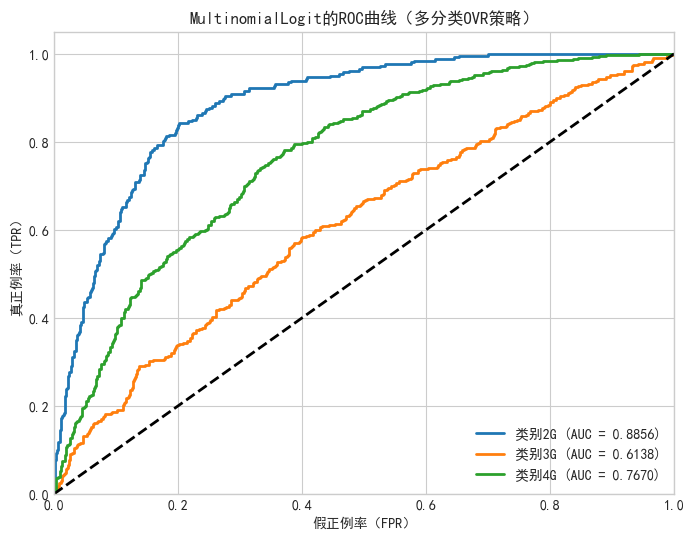

Accuracy : 0.6867
Macro-F1 : 0.4460
混淆矩阵：
[[ 122    0  139]
 [  42    0  313]
 [  37    0 1042]]
分类报告：
              precision    recall  f1-score   support

           0       0.61      0.47      0.53       261
           1       0.00      0.00      0.00       355
           2       0.70      0.97      0.81      1079

    accuracy                           0.69      1695
   macro avg       0.43      0.48      0.45      1695
weighted avg       0.54      0.69      0.60      1695


RandomForest

AUC分数（One-vs-Rest策略）：
类别0（2G）AUC: 0.9268
类别1（3G）AUC: 0.7290
类别2（4G）AUC: 0.8059
macro-AUC（整体）: 0.8206
micro-AUC（整体）: 0.8583


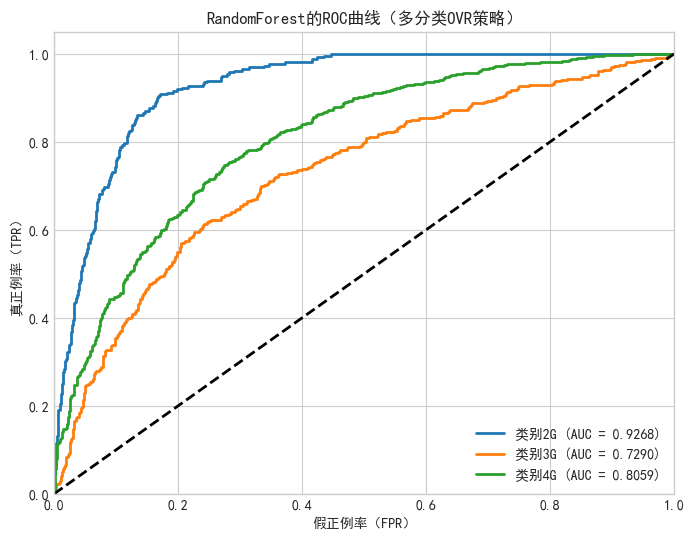

Accuracy : 0.6950
Macro-F1 : 0.6313
混淆矩阵：
[[218   7  36]
 [ 72 150 133]
 [110 159 810]]
分类报告：
              precision    recall  f1-score   support

           0       0.55      0.84      0.66       261
           1       0.47      0.42      0.45       355
           2       0.83      0.75      0.79      1079

    accuracy                           0.69      1695
   macro avg       0.62      0.67      0.63      1695
weighted avg       0.71      0.69      0.70      1695


XGBoost

AUC分数（One-vs-Rest策略）：
类别0（2G）AUC: 0.9325
类别1（3G）AUC: 0.7583
类别2（4G）AUC: 0.8181
macro-AUC（整体）: 0.8363
micro-AUC（整体）: 0.8892


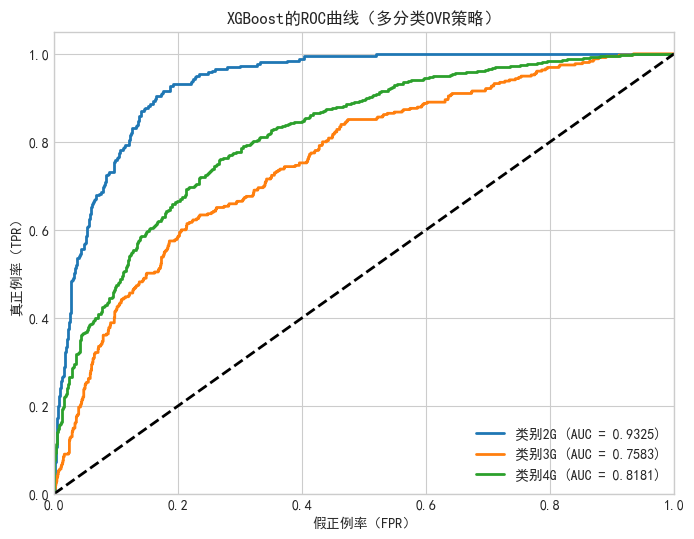

Accuracy : 0.7221
Macro-F1 : 0.5939
混淆矩阵：
[[171  10  80]
 [ 39  74 242]
 [ 50  50 979]]
分类报告：
              precision    recall  f1-score   support

           0       0.66      0.66      0.66       261
           1       0.55      0.21      0.30       355
           2       0.75      0.91      0.82      1079

    accuracy                           0.72      1695
   macro avg       0.65      0.59      0.59      1695
weighted avg       0.70      0.72      0.69      1695


任务3：模型对比
                  Accuracy  Macro-F1
RandomForest      0.694985  0.631291
XGBoost           0.722124  0.593926
MultinomialLogit  0.686726  0.446029


In [11]:
# 任务3（同理修改，移除验证集和早停）
def task3_terminal_type(df_public):
    print("\n" + "=" * 60)
    print("任务3：预测终端类型（2G / 3G / 4G）")
    print("=" * 60)
    
    df3 = df_public[df_public["终端类型"].isin(["2G", "3G", "4G"])].copy()
    print("有效样本数：", df3.shape[0])

    df3["单位流量成本"] = df3["流量收入"] / (df3["上网流量使用"] + 1e-6)
    df3["在网时长分箱"] = pd.cut(
        df3["在网时长"], 
        bins=[0, 12, 36, 1000], 
        labels=["1年以内", "1-3年", "3年以上"]
    )

    drop_cols = ["用户ID", "客户类型", "最近使用操作系统偏好"]
    X, y, _ = preprocess_features(df3, target_col="终端类型", drop_cols=drop_cols)
    y = y.map({"2G": 0, "3G": 1, "4G": 2})
    num_classes = y.nunique()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    models = {
        "MultinomialLogit": LogisticRegression(
            C=0.5,
            max_iter=500,
            multi_class="multinomial",
            n_jobs=-1
        ),
        "RandomForest": rf_grid_search(X_train, y_train, is_multiclass=True),
        "XGBoost": xgb_grid_search(
            X_train, y_train, 
            is_multiclass=True, 
            num_classes=num_classes
        )
    }

    results = {}
    from sklearn.preprocessing import label_binarize

    # 关键：将多分类标签转为二进制（one-hot）格式，用于OVR策略
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # 3类对应3列二进制标签
    n_classes = y_test_bin.shape[1]  # 类别数=3
    
    for name, model in models.items():
        print(f"\n{name}")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # 新增：获取每个类别的预测概率（需模型支持predict_proba方法）
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)  # 形状为(n_samples, n_classes)
        else:
            # 若模型不支持概率输出（如部分简化模型），可跳过或用决策分数
            print(f"{name}不支持概率输出，无法计算ROC-AUC")
            continue
        
        # 计算每个类别的AUC（OVR策略）
        auc_scores = {}
        for i in range(n_classes):
            auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])
            auc_scores[f"类别{i}（{['2G','3G','4G'][i]}）AUC"] = auc
        
        # 计算平均AUC（macro：算术平均，micro：全局平均）
        macro_auc = roc_auc_score(y_test_bin, y_score, average="macro")
        micro_auc = roc_auc_score(y_test_bin, y_score, average="micro")
        auc_scores["macro-AUC（整体）"] = macro_auc
        auc_scores["micro-AUC（整体）"] = micro_auc
        
        # 打印AUC结果
        print("\nAUC分数（One-vs-Rest策略）：")
        for key, value in auc_scores.items():
            print(f"{key}: {value:.4f}")
        
        # 绘制ROC曲线（每个类别一条曲线）
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            plt.plot(fpr, tpr, lw=2, label=f"类别{['2G','3G','4G'][i]} (AUC = {auc_scores[f'类别{i}（{['2G','3G','4G'][i]}）AUC']:.4f})")
        
        # 绘制随机猜测的基准线（AUC=0.5）
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('假正例率（FPR）')
        plt.ylabel('真正例率（TPR）')
        plt.title(f'{name}的ROC曲线（多分类OVR策略）')
        plt.legend(loc="lower right")
        plt.show()
        
        acc = accuracy_score(y_test, y_pred)
        f1m = f1_score(y_test, y_pred, average="macro")

        print(f"Accuracy : {acc:.4f}")
        print(f"Macro-F1 : {f1m:.4f}")
        print("混淆矩阵：")
        print(confusion_matrix(y_test, y_pred))
        print("分类报告：")
        print(classification_report(y_test, y_pred))

        results[name] = [acc, f1m]
        joblib.dump(model, f"task3_{name.lower()}_best_model.pkl")

    res_df = pd.DataFrame(results, index=["Accuracy", "Macro-F1"]).T
    print("\n任务3：模型对比")
    print(res_df.sort_values("Macro-F1", ascending=False))

    return res_df

result3 = task3_terminal_type(df_public)

## **附录**：


任务2：预测是否欠费（严重不平衡二分类）【优化后】
有效样本数量： 8845

---- NaiveBayes ----
Accuracy : 0.2864
Precision: 0.1174
Recall   : 0.8953
F1-score : 0.2075
ROC-AUC  : 0.7014
混淆矩阵：
[[ 512 1865]
 [  29  248]]

---- KNN ----
Accuracy : 0.8745
Precision: 0.2846
Recall   : 0.1336
F1-score : 0.1818
ROC-AUC  : 0.6182
混淆矩阵：
[[2284   93]
 [ 240   37]]

---- NeuralNetwork ----
Accuracy : 0.7792
Precision: 0.2196
Recall   : 0.4368
F1-score : 0.2923
ROC-AUC  : 0.6798
混淆矩阵：
[[1947  430]
 [ 156  121]]


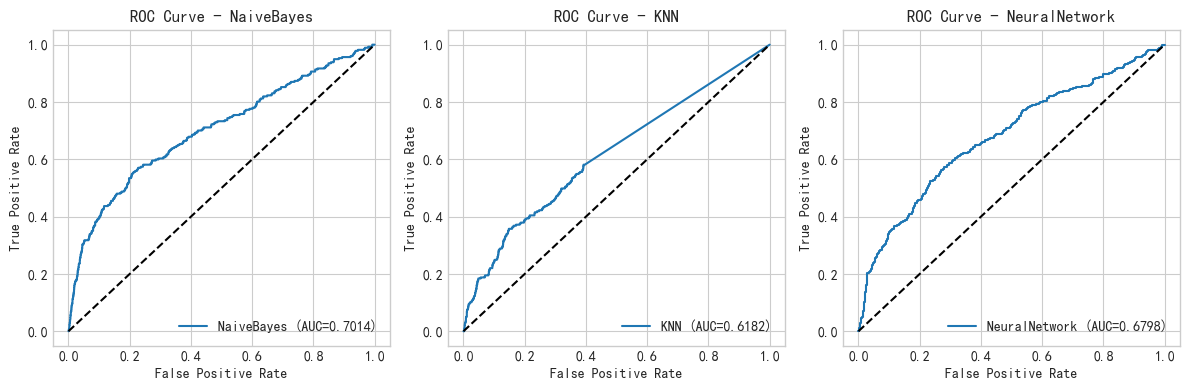



===== 三模型对比（任务2，优化后）=====
               Accuracy  Precision    Recall        F1   ROC-AUC
NaiveBayes     0.286360   0.117369  0.895307  0.207531  0.701359
NeuralNetwork  0.779201   0.219601  0.436823  0.292271  0.679827
KNN            0.874529   0.284615  0.133574  0.181818  0.618178

任务3：预测终端类型（2G / 3G / 4G）【优化后】
有效样本数： 8472

---- NaiveBayes ----
Accuracy : 0.5417
Macro-F1 : 0.5257
混淆矩阵：
[[371  12   8]
 [206 283  43]
 [565 331 723]]
分类报告：
              precision    recall  f1-score   support

          2G     0.3249    0.9488    0.4840       391
          3G     0.4521    0.5320    0.4888       532
          4G     0.9341    0.4466    0.6043      1619

    accuracy                         0.5417      2542
   macro avg     0.5704    0.6425    0.5257      2542
weighted avg     0.7395    0.5417    0.5616      2542


---- KNN ----
Accuracy : 0.7293
Macro-F1 : 0.6208
混淆矩阵：
[[ 184   33  174]
 [  65  239  228]
 [ 100   88 1431]]
分类报告：
              precision    recall  f1-score   support


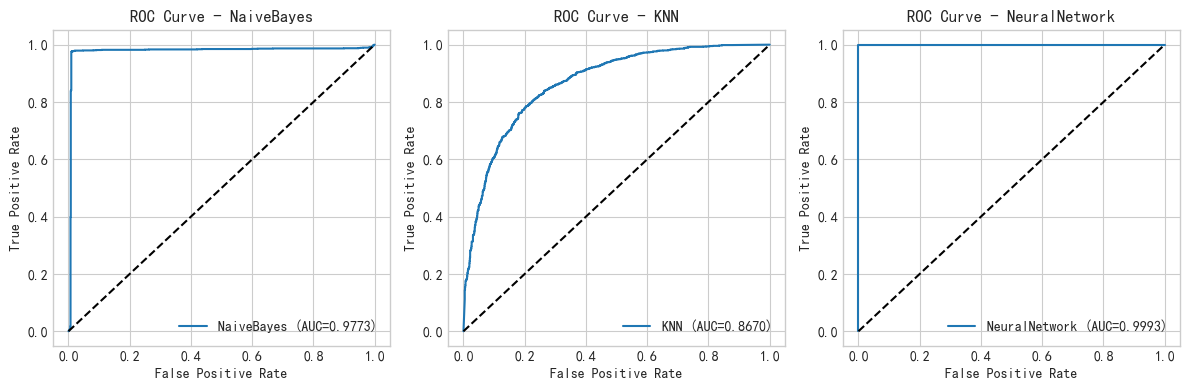


任务4：三模型对比（优化后）
               Accuracy  Precision    Recall        F1   ROC-AUC
NeuralNetwork  0.998863   0.999307  0.998614  0.998960  0.999313
NaiveBayes     0.981811   0.991543  0.975052  0.983229  0.977340
KNN            0.791588   0.791259  0.840610  0.815188  0.867034

任务5：预测操作系统偏好（ANDROID vs IOS）【优化后】
有效样本数： 7836

---- NaiveBayes ----
Accuracy : 0.9855
Precision: 0.9742
Recall   : 0.9919
F1-score : 0.9830
ROC-AUC  : 0.9879
混淆矩阵：
[[1336   26]
 [   8  981]]

---- KNN ----
Accuracy : 0.8962
Precision: 0.8259
Recall   : 0.9545
F1-score : 0.8856
ROC-AUC  : 0.9698
混淆矩阵：
[[1163  199]
 [  45  944]]

---- NeuralNetwork ----
Accuracy : 0.9979
Precision: 0.9970
Recall   : 0.9980
F1-score : 0.9975
ROC-AUC  : 0.9999
混淆矩阵：
[[1359    3]
 [   2  987]]


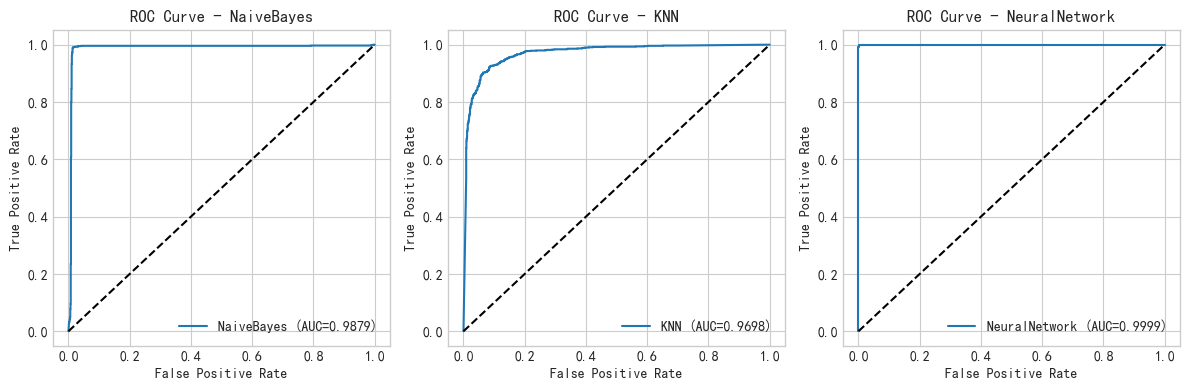


任务5：三模型对比（优化后）
               Accuracy  Precision    Recall        F1   ROC-AUC
NeuralNetwork  0.997873   0.996970  0.997978  0.997473  0.999927
NaiveBayes     0.985538   0.974181  0.991911  0.982966  0.987907
KNN            0.896214   0.825897  0.954499  0.885553  0.969756


In [6]:
# 新增：朴素贝叶斯阈值调整函数（任务2专用）
def predict_with_threshold(model, X, threshold=0.5):
    """用自定义阈值预测，返回预测结果"""
    proba = model.predict_proba(X)[:, 1]  # 正类（欠费）概率
    return (proba >= threshold).astype(int)

# --- 任务2：预测是否欠费（重点优化）---
def task2_predict_arrears(df_public):
    print("\n" + "="*60)
    print("任务2：预测是否欠费（严重不平衡二分类）【优化后】")
    print("="*60)

    df2 = df_public[df_public["是否欠费"].isin(["是","否"])].copy()
    print("有效样本数量：", df2.shape[0])

    target = "是否欠费"
    drop_cols = ["用户ID", "客户类型"]

    y = df2[target].map({"是":1, "否":0})
    X = df2.drop(columns=[target] + drop_cols)

    num_cols = X.select_dtypes(include=[np.number]).columns
    cat_cols = X.select_dtypes(include=["object"]).columns
    X[num_cols] = X[num_cols].fillna(X[num_cols].median())
    X[cat_cols] = X[cat_cols].fillna("Unknown")
    X = pd.get_dummies(X, drop_first=True)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # 标准化（KNN/NeuralNetwork专用）
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 优化后模型参数 - 移除 class_weight
    models = {
        "NaiveBayes": GaussianNB(var_smoothing=1e-8),
        "KNN": KNeighborsClassifier(n_neighbors=5, weights='distance', metric='minkowski', p=2, n_jobs=-1),
        "NeuralNetwork": MLPClassifier(
            hidden_layer_sizes=(50, 30), activation='relu', solver='adam',
            alpha=0.0001, learning_rate_init=0.0005, max_iter=2000,
            early_stopping=True, n_iter_no_change=20, random_state=42
            # class_weight='balanced'  # 已移除
        )
    }

    results = {}
    plt.figure(figsize=(12, 4))

    for i, (name, model) in enumerate(models.items(), 1):
        print(f"\n---- {name} ----")
        if name == "NaiveBayes":
            model.fit(X_train, y_train)
            proba = model.predict_proba(X_test)[:, 1]
            pred = predict_with_threshold(model, X_test, threshold=0.3)
        elif name == "KNN":
            model.fit(X_train_scaled, y_train)
            pred = model.predict(X_test_scaled)
            proba = model.predict_proba(X_test_scaled)[:, 1]
        else:  # NeuralNetwork
            # 对于旧版本sklearn，手动处理类别不平衡
            # 计算类别权重
            classes, counts = np.unique(y_train, return_counts=True)
            weights = {classes[0]: counts[1]/counts[0], classes[1]: 1.0}
            
            # 使用sample_weight进行训练
            sample_weights = np.array([weights[label] for label in y_train])
            model.fit(X_train_scaled, y_train, sample_weight=sample_weights)
            
            pred = model.predict(X_test_scaled)
            proba = model.predict_proba(X_test_scaled)[:, 1]

        # 计算指标
        acc = accuracy_score(y_test, pred)
        prec = precision_score(y_test, pred, zero_division=0)
        rec = recall_score(y_test, pred, zero_division=0)
        f1 = f1_score(y_test, pred, zero_division=0)
        auc_val = roc_auc_score(y_test, proba) if proba is not None else "N/A"

        # 输出结果
        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1-score : {f1:.4f}")
        print(f"ROC-AUC  : {auc_val:.4f}" if auc_val != "N/A" else "ROC-AUC  : N/A")
        print("混淆矩阵：")
        print(confusion_matrix(y_test, pred))

        results[name] = [acc, prec, rec, f1, auc_val]

        # 绘制ROC曲线
        if auc_val != "N/A":
            fpr, tpr, _ = roc_curve(y_test, proba)
            plt.subplot(1, 3, i)
            plt.plot(fpr, tpr, label=f'{name} (AUC={auc_val:.4f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {name}')
            plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

    # 结果对比表
    res_df = pd.DataFrame(
        results,
        index=["Accuracy","Precision","Recall","F1","ROC-AUC"]
    ).T
    print("\n\n===== 三模型对比（任务2，优化后）=====")
    print(res_df.sort_values("ROC-AUC", ascending=False))

    return res_df

# --- 任务3：预测终端类型（2G/3G/4G）【微调KNN】---
def task3_terminal_type(df_public):
    print("\n" + "=" * 60)
    print("任务3：预测终端类型（2G / 3G / 4G）【优化后】")
    print("=" * 60)
    
    df3 = df_public[df_public["终端类型"].isin(["2G", "3G", "4G"])].copy()
    print("有效样本数：", df3.shape[0])

    drop_cols = ["用户ID", "客户类型"]
    X, y, _ = preprocess_features(df3, target_col="终端类型", drop_cols=drop_cols)
    y = y.map({"2G": 0, "3G": 1, "4G": 2})

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 优化后模型参数 - 移除 class_weight
    models = {
        "NaiveBayes": GaussianNB(var_smoothing=1e-8),
        "KNN": KNeighborsClassifier(n_neighbors=10, weights='distance', metric='minkowski', p=2, n_jobs=-1),
        "NeuralNetwork": MLPClassifier(
            hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
            alpha=0.0001, learning_rate_init=0.001, max_iter=1000,
            early_stopping=True, n_iter_no_change=15, random_state=42
            # class_weight='balanced'  # 已移除
        )
    }

    results = {}
    for name, model in models.items():
        print(f"\n---- {name} ----")
        if name == "NaiveBayes":
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        else:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

        acc = accuracy_score(y_test, y_pred)
        f1m = f1_score(y_test, y_pred, average="macro")

        print(f"Accuracy : {acc:.4f}")
        print(f"Macro-F1 : {f1m:.4f}")
        print("混淆矩阵：")
        print(confusion_matrix(y_test, y_pred))
        print("分类报告：")
        print(classification_report(y_test, y_pred, target_names=['2G', '3G', '4G'], digits=4))

        results[name] = [acc, f1m]

    res_df = pd.DataFrame(results, index=["Accuracy", "Macro-F1"]).T
    print("\n任务3：三模型对比（优化后）")
    print(res_df.sort_values("Macro-F1", ascending=False))

    return res_df

# --- 任务4：预测渠道类型（社会渠道vs自有渠道）【微调KNN】---
def task4_channel(df_public):
    print("\n" + "=" * 60)
    print("任务4：预测渠道类型（社会渠道 vs 自有渠道）【优化后】")
    print("=" * 60)

    df4 = df_public[df_public["渠道类型描述"].isin(["社会渠道", "自有渠道"])].copy()
    print("有效样本数：", df4.shape[0])

    drop_cols = ["用户ID", "客户类型"]
    X, y, _ = preprocess_features(df4, target_col="渠道类型描述", drop_cols=drop_cols)
    y = y.map({"社会渠道": 1, "自有渠道": 0})

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 优化后模型参数 - 移除 class_weight
    models = {
        "NaiveBayes": GaussianNB(var_smoothing=1e-8),
        "KNN": KNeighborsClassifier(n_neighbors=10, weights='distance', metric='minkowski', p=2, n_jobs=-1),
        "NeuralNetwork": MLPClassifier(
            hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
            alpha=0.0001, learning_rate_init=0.001, max_iter=1000,
            early_stopping=True, n_iter_no_change=15, random_state=42
            # class_weight='balanced'  # 已移除
        )
    }

    results = {}
    plt.figure(figsize=(12, 4))
    for i, (name, model) in enumerate(models.items(), 1):
        print(f"\n---- {name} ----")
        if name == "NaiveBayes":
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            proba = model.predict_proba(X_test)[:, 1]
        else:
            model.fit(X_train_scaled, y_train)
            pred = model.predict(X_test_scaled)
            proba = model.predict_proba(X_test_scaled)[:, 1]

        acc = accuracy_score(y_test, pred)
        prec = precision_score(y_test, pred)
        rec = recall_score(y_test, pred)
        f1 = f1_score(y_test, pred)
        auc_val = roc_auc_score(y_test, proba)

        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1-score : {f1:.4f}")
        print(f"ROC-AUC  : {auc_val:.4f}")
        print("混淆矩阵：")
        print(confusion_matrix(y_test, pred))

        results[name] = [acc, prec, rec, f1, auc_val]

        fpr, tpr, _ = roc_curve(y_test, proba)
        plt.subplot(1, 3, i)
        plt.plot(fpr, tpr, label=f'{name} (AUC={auc_val:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

    res_df = pd.DataFrame(
        results,
        index=["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]
    ).T
    print("\n任务4：三模型对比（优化后）")
    print(res_df.sort_values("ROC-AUC", ascending=False))

    return res_df

# --- 任务5：预测操作系统偏好（ANDROID vs IOS）【微调KNN】---
def task5_os_preference(df_public):
    print("\n" + "=" * 60)
    print("任务5：预测操作系统偏好（ANDROID vs IOS）【优化后】")
    print("=" * 60)
    
    def simplify_os(x):
        if isinstance(x, str):
            xu = x.upper()
            if "ANDROID" in xu:
                return "ANDROID"
            if "IOS" in xu:
                return "IOS"
        return None

    df5 = df_public.copy()
    df5["最近使用操作系统偏好"] = df5["最近使用操作系统偏好"].apply(simplify_os)
    df5 = df5[df5["最近使用操作系统偏好"].isin(["ANDROID", "IOS"])].copy()
    print("有效样本数：", df5.shape[0])

    drop_cols = ["用户ID", "客户类型"]
    X, y, _ = preprocess_features(df5, target_col="最近使用操作系统偏好", drop_cols=drop_cols)
    y = y.map({"ANDROID": 0, "IOS": 1})

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 优化后模型参数 - 移除 class_weight
    models = {
        "NaiveBayes": GaussianNB(var_smoothing=1e-8),
        "KNN": KNeighborsClassifier(n_neighbors=10, weights='distance', metric='minkowski', p=2, n_jobs=-1),
        "NeuralNetwork": MLPClassifier(
            hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
            alpha=0.0001, learning_rate_init=0.001, max_iter=1000,
            early_stopping=True, n_iter_no_change=15, random_state=42
            # class_weight='balanced'  # 已移除
        )
    }

    results = {}
    plt.figure(figsize=(12, 4))
    for i, (name, model) in enumerate(models.items(), 1):
        print(f"\n---- {name} ----")
        if name == "NaiveBayes":
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            proba = model.predict_proba(X_test)[:, 1]
        else:
            model.fit(X_train_scaled, y_train)
            pred = model.predict(X_test_scaled)
            proba = model.predict_proba(X_test_scaled)[:, 1]

        acc = accuracy_score(y_test, pred)
        prec = precision_score(y_test, pred)
        rec = recall_score(y_test, pred)
        f1 = f1_score(y_test, pred)
        auc_val = roc_auc_score(y_test, proba)

        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1-score : {f1:.4f}")
        print(f"ROC-AUC  : {auc_val:.4f}")
        print("混淆矩阵：")
        print(confusion_matrix(y_test, pred))

        results[name] = [acc, prec, rec, f1, auc_val]

        fpr, tpr, _ = roc_curve(y_test, proba)
        plt.subplot(1, 3, i)
        plt.plot(fpr, tpr, label=f'{name} (AUC={auc_val:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

    res_df = pd.DataFrame(
        results,
        index=["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]
    ).T
    print("\n任务5：三模型对比（优化后）")
    print(res_df.sort_values("ROC-AUC", ascending=False))

    return res_df


# 执行任务
result2 = task2_predict_arrears(df_public)
result3 = task3_terminal_type(df_public)
result4 = task4_channel(df_public)
result5 = task5_os_preference(df_public)